In [1]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [17]:
import os
from os.path import basename, dirname, join


import glob
import argparse
import datetime
import random
import json

from netCDF4 import Dataset
from PIL import Image
import numpy as np
import seaborn as sebrn
import data_generator
from data_generator import HugoDataGenerator, DataGenerator_sod_f, DataGenerator_sod_f_all, HugoBinaryGenerator, HugoSarDataGenerator,  HugoAMRS2DataGenerator

import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.metrics import (confusion_matrix, 
                            mean_squared_error, 
                            accuracy_score,
                            precision_score,
                            recall_score)
from scipy import stats
from scipy.ndimage import distance_transform_edt, zoom
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     Flatten,
                                     Dropout,
                                     BatchNormalization, 
                                     Conv2D, 
                                     MaxPooling2D)
from tensorflow.keras.regularizers import l2
from mpl_toolkits.axes_grid1 import make_axes_locatable



os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)


# Network 32

In [28]:
list_combi =["0_0", "82_2", "82_3", "82_4", "82_5", "83_3","83_4", "83_5", "83_6","87_3","87_4","87_5", "87_6", "91_2","91_3","91_4", "91_5", "91_6", "91_7", "93_2", 
             "93_3","93_4","93_5", "93_6", "93_7","95_3","95_4", "95_5", "95_6","95_7", "96_6","97_7"]    
nb_class=len(list_combi)
with open(f'{input_dir_json}/vector_combinations.json') as fichier_json:
    list_combi_n = json.load(fichier_json)['all_work_comb']

In [5]:
def convert (array):
    """
    Do nothing for HugoDataGenerator and Datageneratorsod_f
    """
    return array
    
def ice_type(combi):
        """
        
        Parameters
        ----------
        combi : string
            the combinaison of the sod and form 
        Returns
        -------
        index_ : integer
            index of the list where the value will be.
        """
        index_= -9
        if combi =='0_0':
            index_ = 0
        if combi in ('82_2', '82_3', '82_4', '82_5', '83_3', '83_4'):
            index_ = 1
        if combi =='83_5':
            index_ = 2
        if combi in ('83_6', '87_3', '87_4', '87_5'):
            index_ = 3
        if combi =='87_6':
            index_ = 4
        if combi in ('91_2', '91_3', '91_4'):
            index_ = 5
        if combi =='91_5':
            index_ = 6
        if combi =='91_6':
            index_ = 7
        if combi =='91_7':
            index_ = 8
        if combi =='93_2':
            index_ = 9
        if combi in ('93_3', '93_4', '93_5'):
            index_ = 10
        if combi =='93_6':
            index_ = 11
        if combi =='93_7':
            index_ = 12
        if combi in ('95_3', '95_4'):
            index_ = 13
        if combi =='95_5':
            index_ = 14
        if combi in ('95_6', '95_7'):
            index_ = 15
        if combi in ('96_6', '97_7'):
            index_ = 16
        if index_ == -9:
            index_ = 17
        return index_   
    
    
def one_hot_continous(self, vector_param):
        """
        Converts the output parameter vector ([ct,ca,sa,fa,...])
        into a vector that contains the concentration percentages for the combinations.

        Parameters
        ----------
        vector_param : list
            all parameters in a vector.

        Returns
        -------
        result : list
            List of percentage concentrations for each work combination.
        """

        result = [0]*(nb_class+1)
        vector_param = vector_param.squeeze()
        if vector_param[0] < 10 : #open weter
            combi = "0_0"
            index_combi = 0
            result[index_combi] = 1
        for ice in range(3): # in a output there are 3 data for the 3 most present ice
            if vector_param[1+ice*3] == (-9):
                continue
            if vector_param[2+ice*3] == (-9):
                continue
            if vector_param[3+ice*3] == (-9):
                continue
            combi = str(int(vector_param[2+ice*3])) + '_' + str(int(vector_param[3+ice*3]))
            
            index_combi = list_combi.index(combi)
            result[index_combi] += vector_param[1+ice*3]/100
        if max(result) == 0:
            combi = str(int(vector_param[2])) + '_' + str(int(vector_param[3]))
            index_combi = list_combi.index(combi)
            result[index_combi] += round(vector_param[0]/100,1)
            result[0] = 1-sum(result[1:])
        else:
            result[0] = 1-sum(result[1:])
        result = convert(result)
        result = result[:nb_class]
        return np.round(result,1)

In [6]:
idir = '/tf/data/hugo_sod/output_preprocessed/'
input_dir_json = '/tf/data/hugo_sod/'
idir_model = '/tf/sea_ice_type_cnn_training/asip_v2/CNN_sod_f/all classes/model_sod_50_nopatience/'

In [7]:
train_ratio = 0.7
with open(f'{idir}processed_files.json') as fichier_json:
    all_nc = json.load(fichier_json)
npz_files=[]

for nc in all_nc :
    name = nc[:15]
    files = sorted(glob.glob(f'{idir}/{name}/*.npz'))
    npz_files += files
random.shuffle(npz_files)


print('Files number : '+ str (len(npz_files)))
train_files_number = int(len(npz_files) * train_ratio)
valid_files = npz_files[train_files_number:]

input_var_names = ['nersc_sar_primary', 'nersc_sar_secondary']
amsr2_var_names = ['btemp_6_9h',
                   'btemp_6_9v',
                   'btemp_7_3h',
                   'btemp_7_3v',
                   'btemp_10_7h',
                   'btemp_10_7v',
                   'btemp_18_7h',
                   'btemp_18_7v',
                   'btemp_23_8h',
                   'btemp_23_8v',
                   'btemp_36_5h',
                   'btemp_36_5v',
                   'btemp_89_0h',
                   'btemp_89_0v'
                  ]

output_var_name = 'ice_type'
dims_amsr2 = np.load(npz_files[0])[amsr2_var_names[0]].shape


params = {'dims_amsr2':      (*dims_amsr2, len(amsr2_var_names)),
          'idir_json':       input_dir_json,
          'output_var_name': output_var_name,
          'input_var_names': input_var_names,
          'amsr2_var_names': amsr2_var_names,
          'batch_size':      50,
          'shuffle_on_epoch_end': False,
           }

validation_generator = DataGenerator_sod_f_all(valid_files, **params)

Files number : 888522


In [8]:
modelbis = keras.models.load_model(idir_model)

In [10]:
y_val = np.vstack([vg[1] for vg in validation_generator])

In [11]:

print(y_val[:20])

[[0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.4 0.  0.  0.  0.  0.  0.5
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.9 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.3 0.  0.  0.  0.
  0.  0.  0.  0.4 0.  0.  0.  0.3 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.4
  0.  0.  0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.
  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.4 0.  0.  0.  0.  0.6 0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.4 0.
  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 

In [13]:
y_pred = modelbis.predict(validation_generator)

5331/5331 [==============================] - 1563s 293ms/step


In [23]:
print(y_pred[:20])

[[2.90081128e-02 1.01451494e-01 3.19890538e-03 1.13618784e-01
  7.58250803e-03 5.40441321e-03 3.02087609e-03 6.22686278e-03
  1.20395599e-02 5.97238541e-03 7.74105126e-03 7.93840457e-03
  7.50839934e-02 1.55968279e-01 1.10391758e-01 9.10601404e-04
  1.28686149e-02 4.71283682e-03 1.20356064e-02 1.43686635e-02
  9.45767239e-02 6.58863515e-04 5.32425102e-03 3.02893422e-05
  3.23602394e-03 5.55035472e-03 2.57714157e-04 4.30633314e-03
  6.88470528e-03 1.79339200e-01 9.76721756e-03 5.24674251e-04]
 [7.61269450e-01 9.83821913e-10 2.13975160e-04 6.62462185e-07
  2.94052772e-02 6.64269123e-14 1.33682834e-05 9.10368040e-02
  7.25983773e-05 5.98142014e-06 2.83222701e-02 1.84767470e-02
  3.20643157e-05 1.49808431e-04 1.50496780e-04 8.57555096e-06
  7.38183036e-04 3.70720439e-02 1.11137819e-03 2.99800940e-05
  7.75058993e-07 1.35661116e-06 1.70271366e-03 1.34916718e-07
  9.99694385e-06 2.74729100e-04 1.32657749e-06 2.98572928e-02
  2.65326398e-05 1.10549754e-05 1.02427975e-06 3.37784331e-06]
 [1.49

## matrix 32

In [41]:
rmse_matrix=np.empty((32,32))
pearson_matrix = np.empty((32,32))
rrmse_matrix=np.empty((32,32))
for id_class_pred in range(y_pred.shape[1]):
    classes_pred = y_pred[:,id_class_pred]
    for id_class_val in range (y_val.shape[1]):
        classes_val = y_val[:,id_class_val]
        rmse = mean_squared_error(classes_val, classes_pred)
        rmse_matrix[id_class_pred][id_class_val] = rmse
        rrmse = rmse / classes_val.std()
        rrmse_matrix[id_class_pred][id_class_val] = rrmse
        pearson_value = stats.pearsonr(classes_val, classes_pred)
        pearson_matrix[id_class_pred][id_class_val] = pearson_value[0]
        


In [42]:
pm_all=np.empty((32,32))
rmse_all=np.empty((32,32))
rrmse_all=np.empty((32,32))
for i in range(pearson_matrix.shape[1]):
    index= list_combi_n.index(list_combi[i])
    pm_all [i,:]=pearson_matrix[index,:]
    rmse_all [i,:]=rmse_matrix[index,:]
    rrmse_all [i,:]=rrmse_matrix[index,:]

<Figure size 640x480 with 0 Axes>

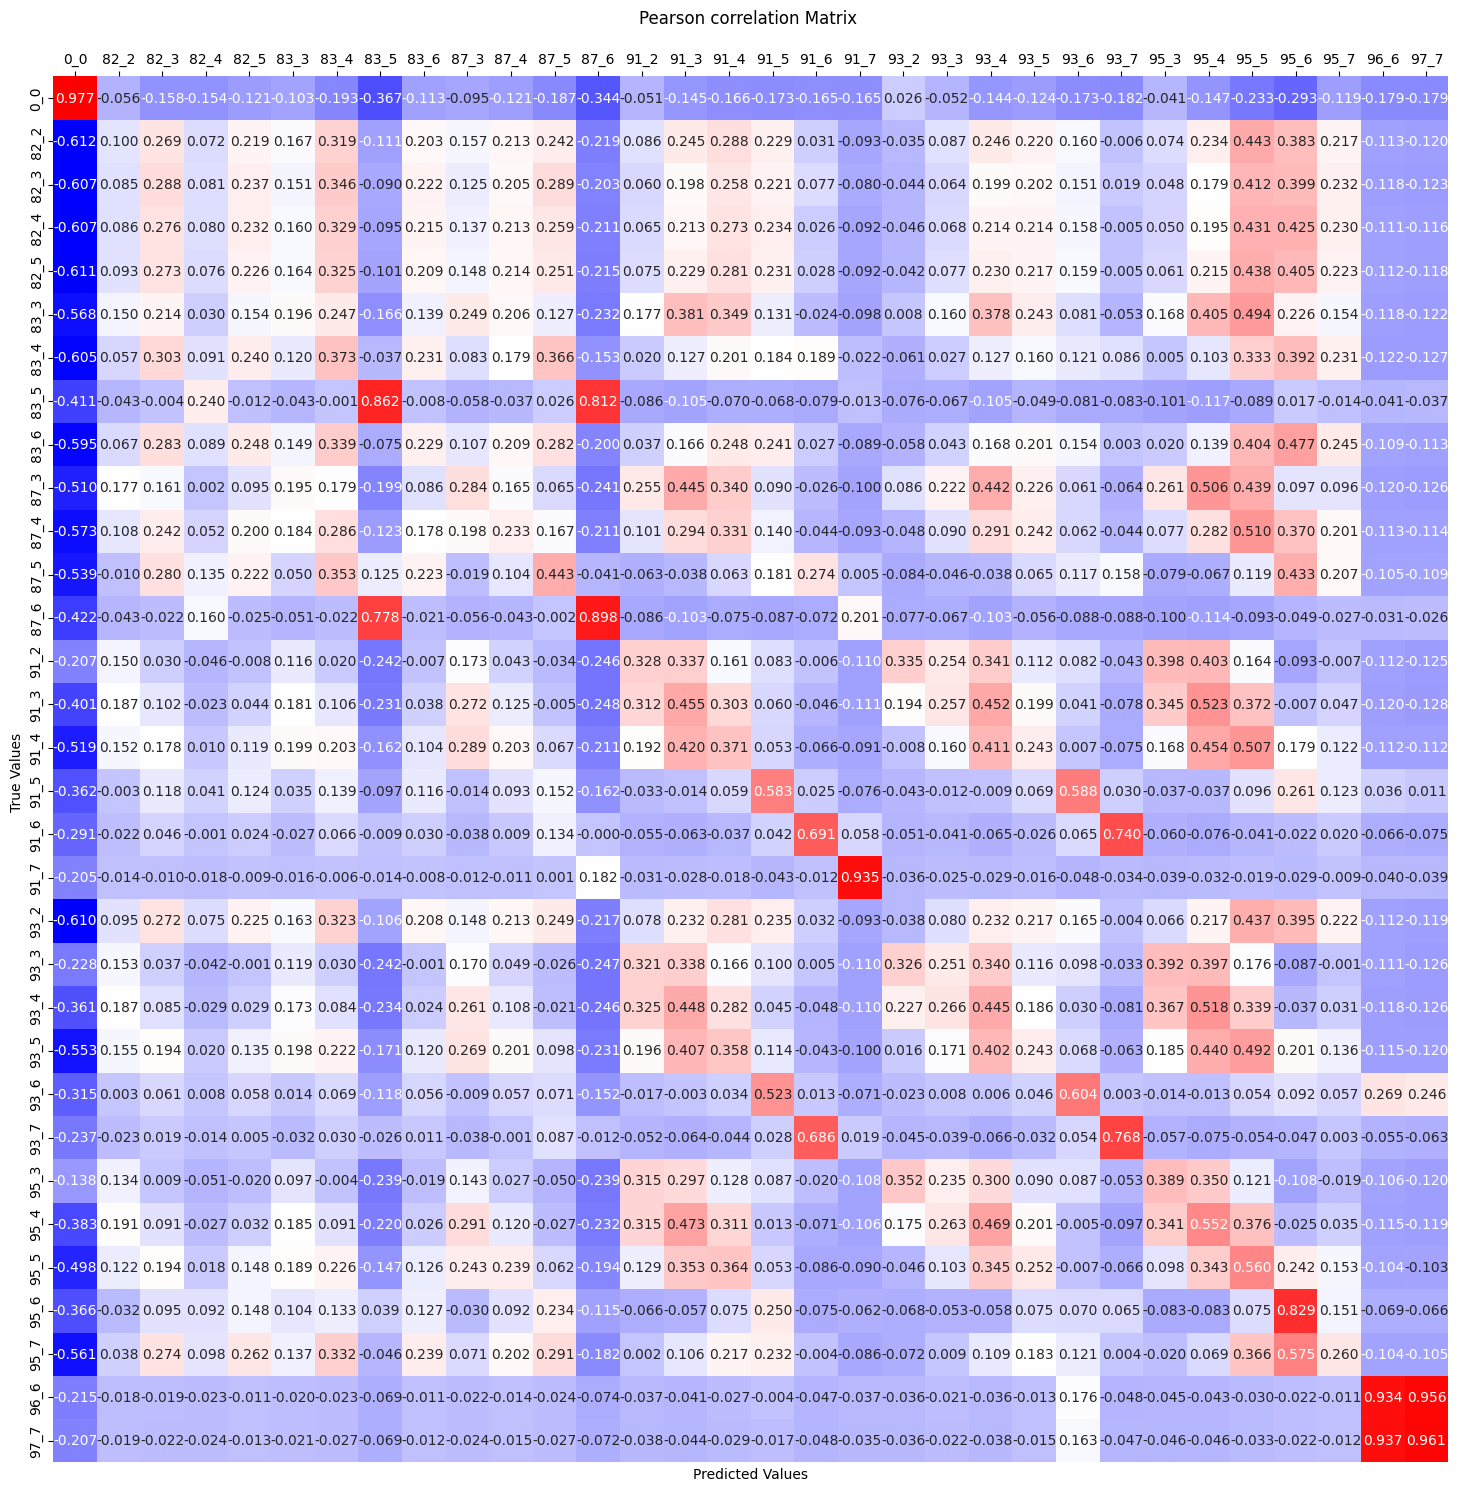

In [38]:
with open(f'{input_dir_json}/vector_combinations.json') as fichier_json:
    list_combi = sorted(json.load(fichier_json)['all_work_comb'])
y_ticks= [(i+0.5) for i in range (32)]


plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(pm, annot=True, cmap='bwr', fmt=".3f", cbar=False)
fx.set_title('Pearson correlation Matrix \n')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values ')
fx.xaxis.set_ticklabels(list_combi)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi)
plt.show()

<Figure size 640x480 with 0 Axes>

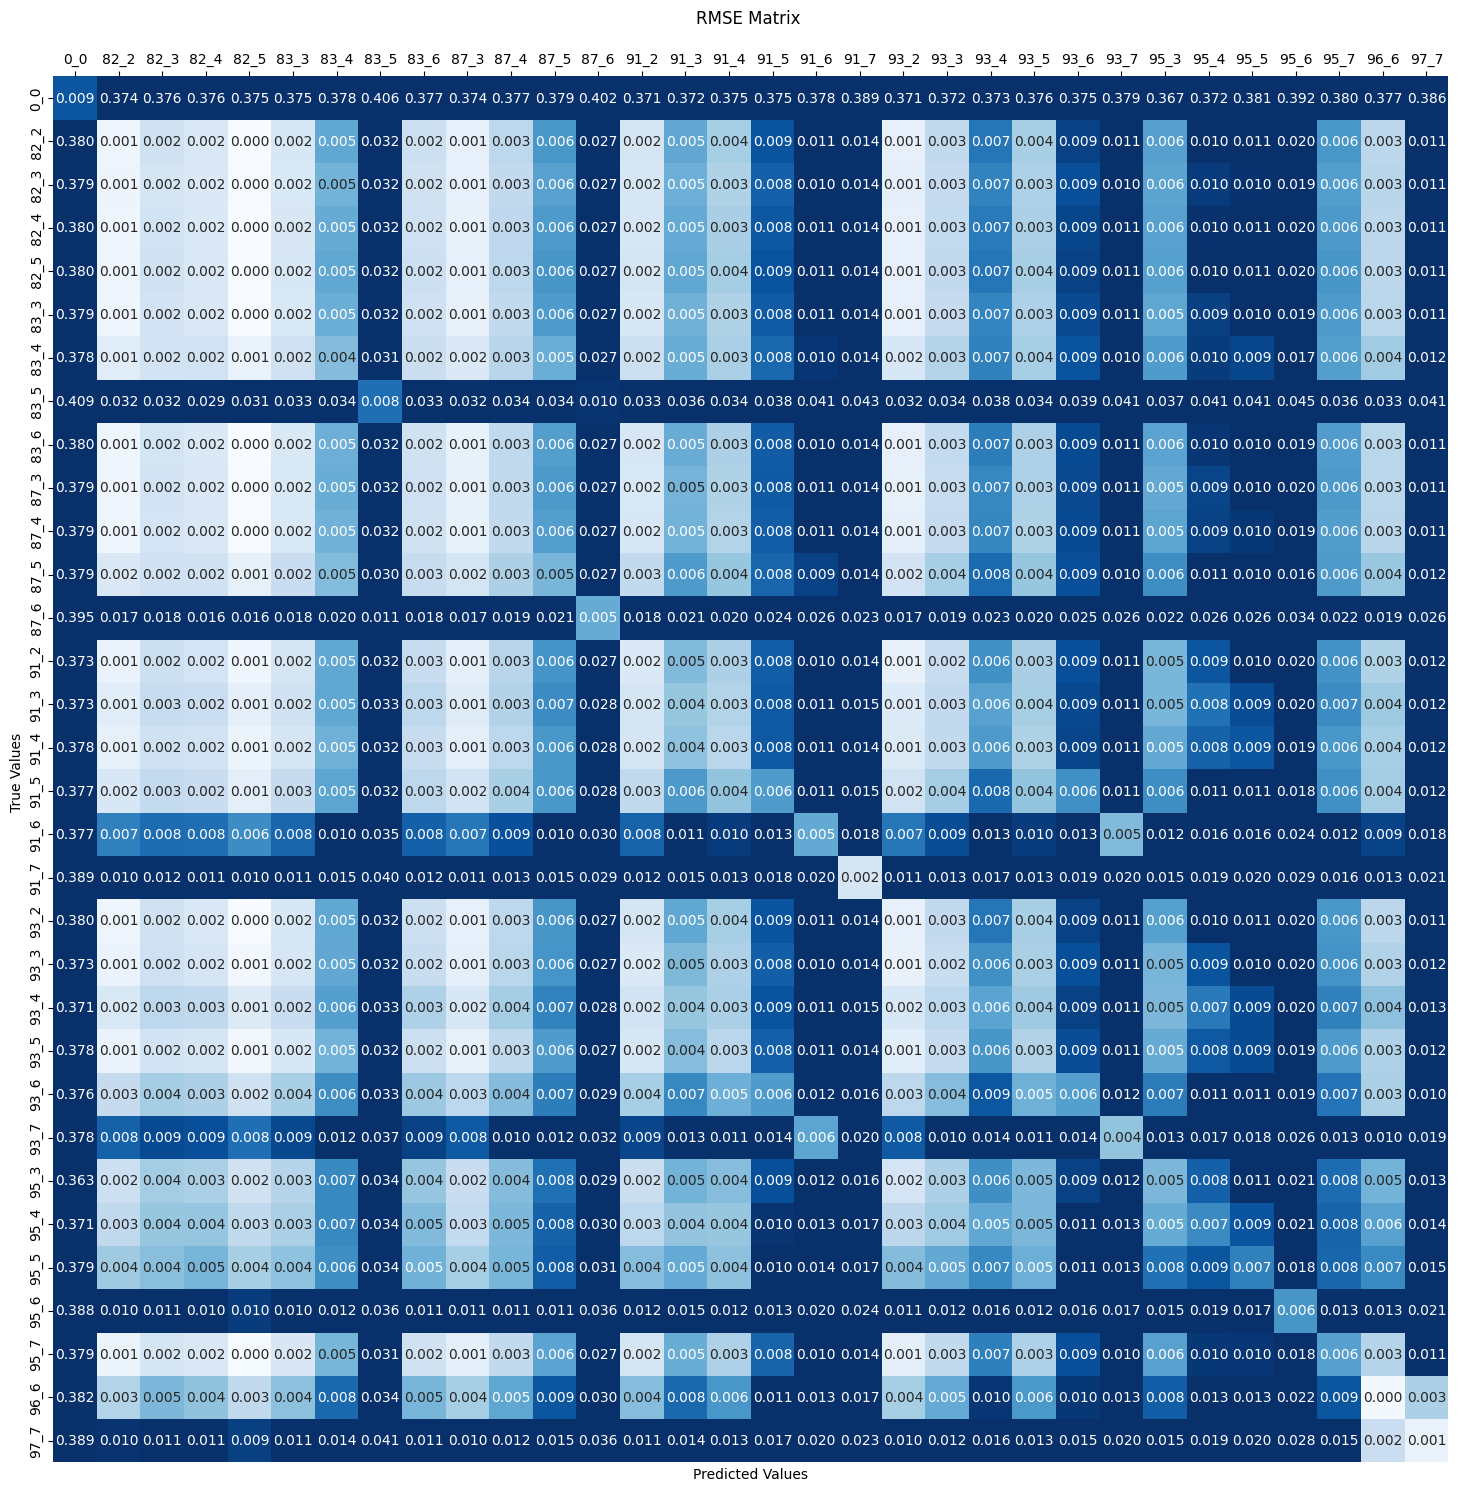

<Figure size 640x480 with 0 Axes>

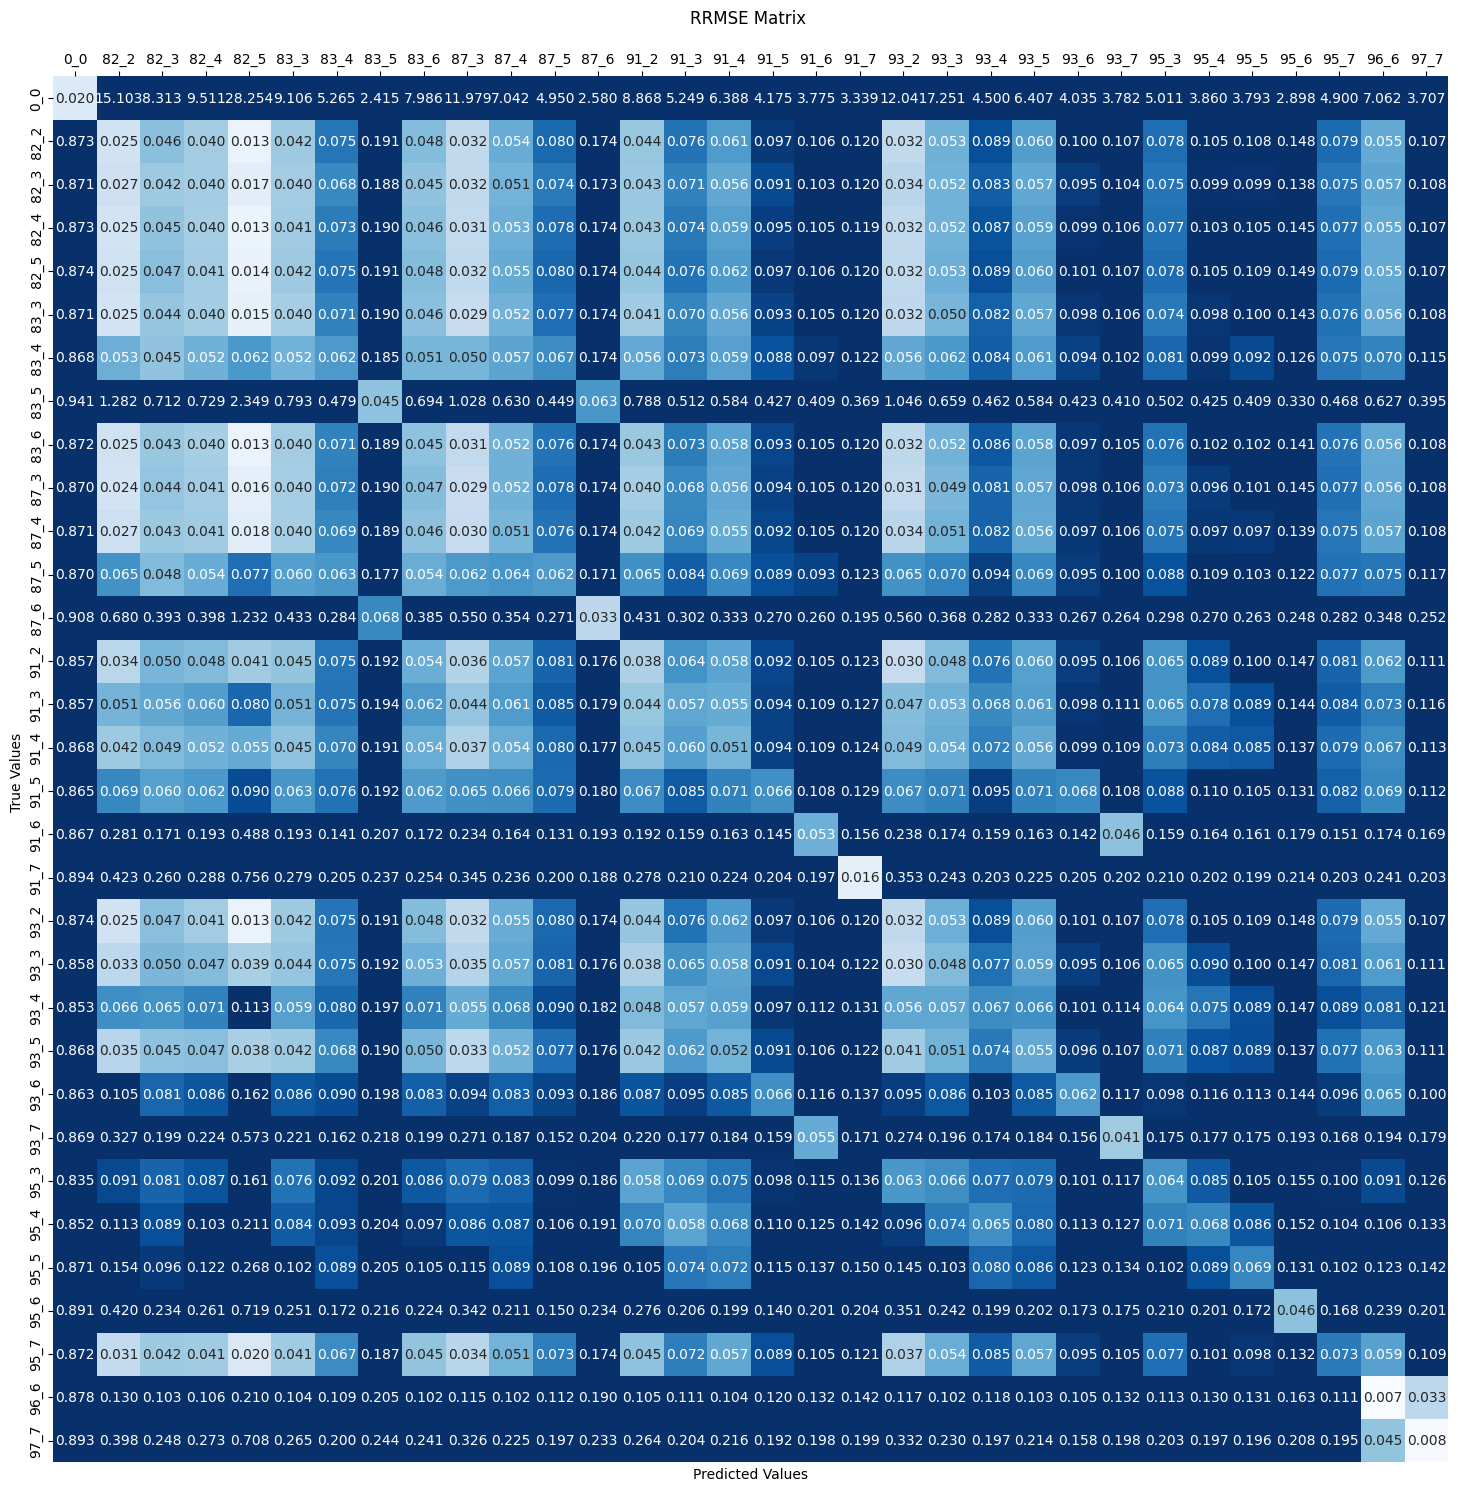

In [46]:
plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(rmse_all, annot=True, cmap='Blues', fmt=".3f", cbar=False, vmax=0.01)
fx.set_title('RMSE Matrix \n')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values ')
fx.xaxis.set_ticklabels(list_combi)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi)
plt.savefig('rmse_matrix_sod_50_17_nopatience')
plt.show()

plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(rrmse_all, annot=True, cmap='Blues', fmt=".3f", cbar=False,  vmax=0.1)
fx.set_title('RRMSE Matrix \n')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values ')
fx.xaxis.set_ticklabels(list_combi)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi)
plt.savefig('rrmse_matrix_sod_50_17_nopatience')
plt.show()

## Matrix 17

In [47]:
nbr_classes = 17
list_combi_17 =["0_0", "82_2_3_4_5_83_3_4", "83_5", "83_6_87_3_4_5", "87_6", "91_2_3_4", "91_5", "91_6", "91_7", "93_2", 
             "93_3_4_5", "93_6", "93_7","95_3_4", "95_5", "95_6_7", "96_6_97_7"]    
list_index_sum =[0,[1,2,3,4,5,6],7,[8,9,10,11],12,[13,14,15],16,17,18,19,[20,21,22],23,24,[25,26],27,[28,29],[30,31]]

In [66]:
list_combi_n = ["0_0", "83_5", "93_6", "87_6", "95_4", "95_6", "91_5", "95_3", "95_5", "83_6", "93_4",
                "91_3", "83_4", "91_6", "93_7", "96_6", "91_4", "91_2", "93_5", "82_3", "87_5", 
                "97_7", "87_3", "82_5", "82_4", "83_3", "93_2", "93_3", "87_4", "91_7", "95_7",
                "82_2"]
# 87-94 95-..

list_index_sum_pred = [0,[31,19,24,23,25,12],1,[9,22,28,20],3,[17,11,16],6,13,29,26,[27,10,18],2,14,[7,4],8,[5,30],[15,21]]

In [67]:
samples_17_val =[0]*17
samples_17_pred =[0]*17
for sample_val, sample_pred in zip (y_val, y_pred):
    sample_val_17 =[]
    sample_pred_17 =[]
    for index in list_index_sum:
        sum_group_val= np.sum(np.array([sample_val[index]]))
        sample_val_17.append(sum_group_val)
    for index_pre in list_index_sum_pred:
        sum_group_pred= np.sum(np.array([sample_pred[index_pre]]))
        sample_pred_17.append(sum_group_pred)
    samples_17_val = np.vstack((samples_17_val, sample_val_17))
    samples_17_pred = np.vstack((samples_17_pred, sample_pred_17))


In [68]:
samples_17_val=samples_17_val[1:]
samples_17_pred=samples_17_pred[1:]

In [69]:
rmse_matrix_17=np.empty((17,17))
pearson_matrix_17 = np.empty((17,17))
rrmse_matrix_17=np.empty((17,17))
for id_class_pred in range(samples_17_pred.shape[1]):
    classes_pred = samples_17_pred[:,id_class_pred]
    for id_class_val in range (samples_17_val.shape[1]):
        classes_val = samples_17_val[:,id_class_val]
        rmse = mean_squared_error(classes_val, classes_pred)
        rmse_matrix_17[id_class_pred][id_class_val] = rmse
        rrmse = rmse / classes_val.std()
        rrmse_matrix_17[id_class_pred][id_class_val] = rrmse
        pearson_value = stats.pearsonr(classes_val, classes_pred)
        pearson_matrix_17[id_class_pred][id_class_val] = pearson_value[0]

In [ ]:
# pm_17=np.empty((17,17))
# rmse_17=np.empty((17,17))
# rrmse_17=np.empty((17,17))
# for i in range(pearson_matrix_17.shape[1]):
    
#     index= list_combi_n.index(list_combi[i])
    
#     pm_17 [i,:]=pearson_matrix_17[index,:]
#     rmse_17 [i,:]=rmse_matrix_17[index,:]
#     rrmse_17 [i,:]=rrmse_matrix_17[index,:]

<Figure size 640x480 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

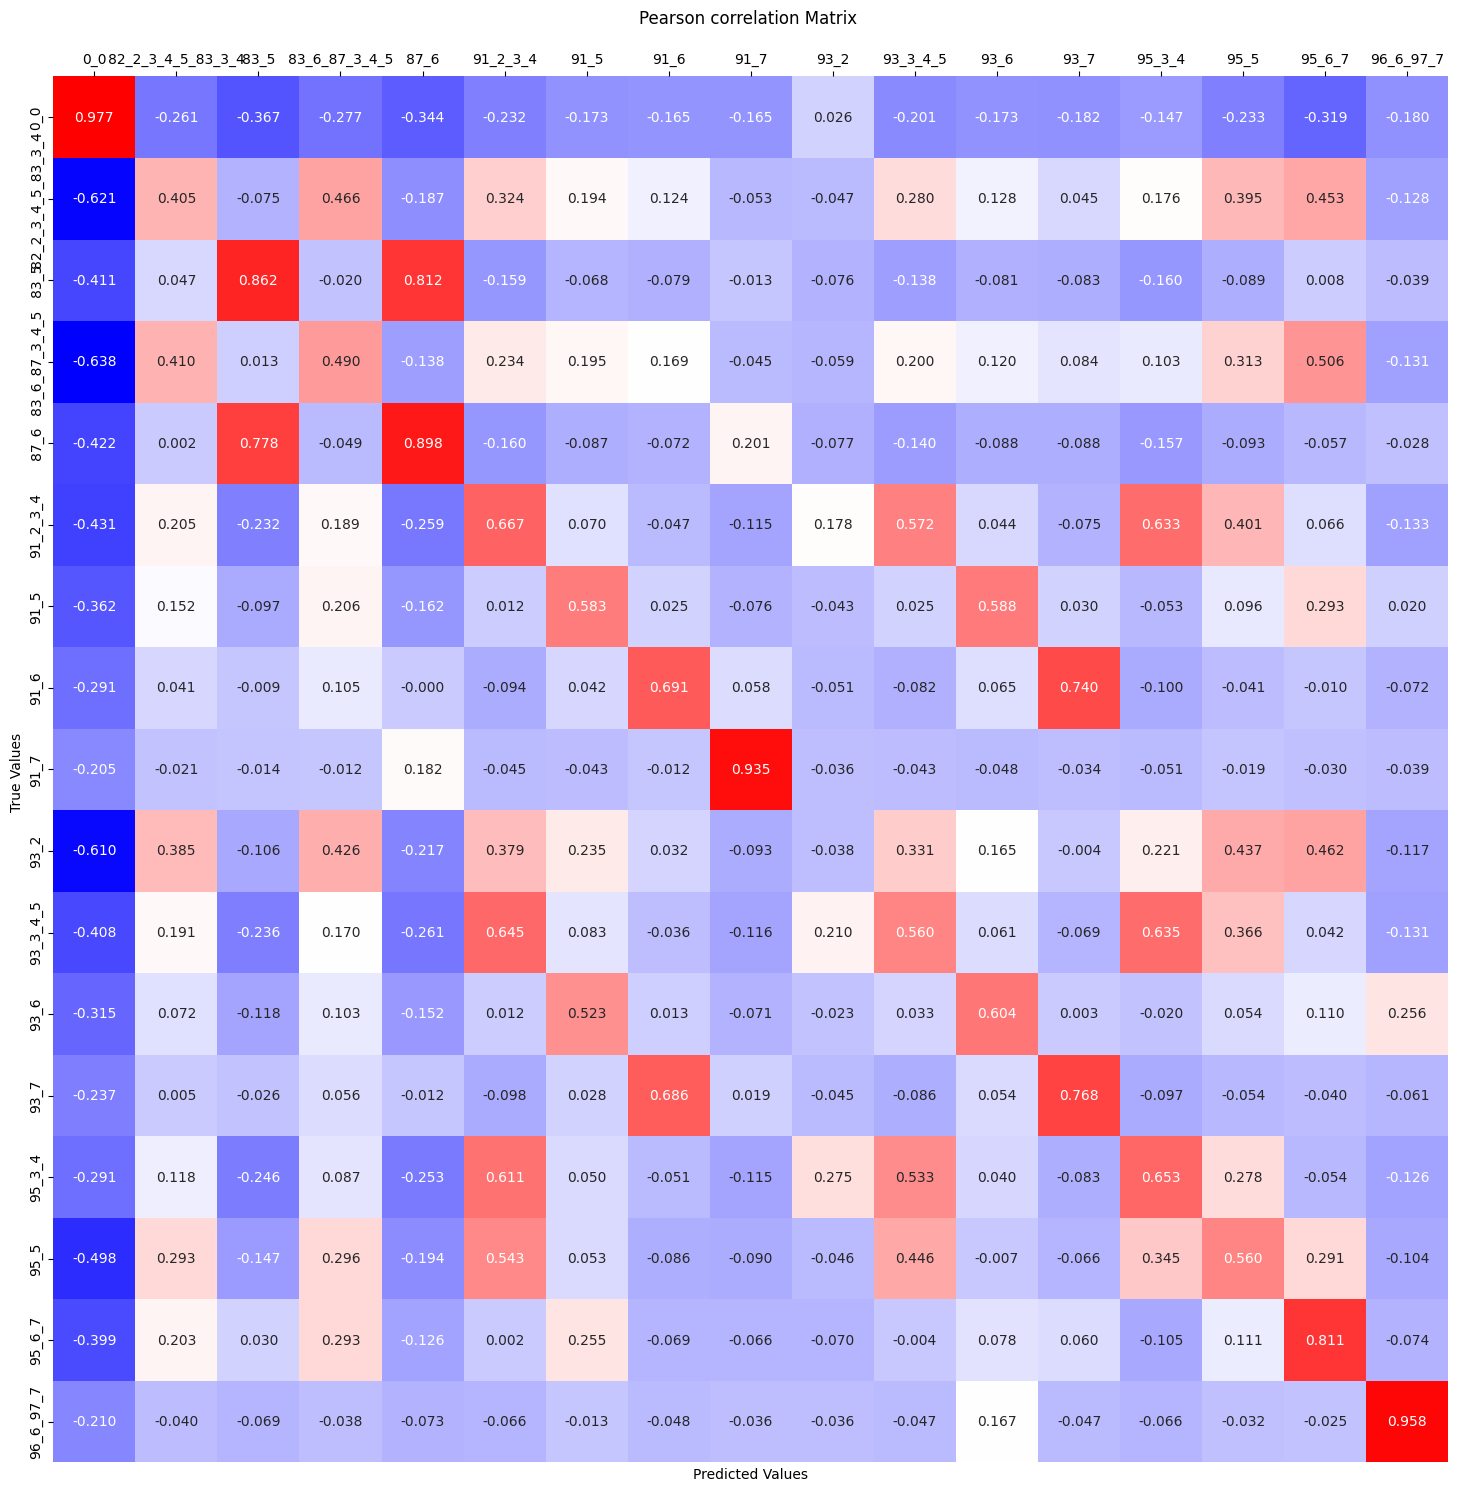

<Figure size 640x480 with 0 Axes>

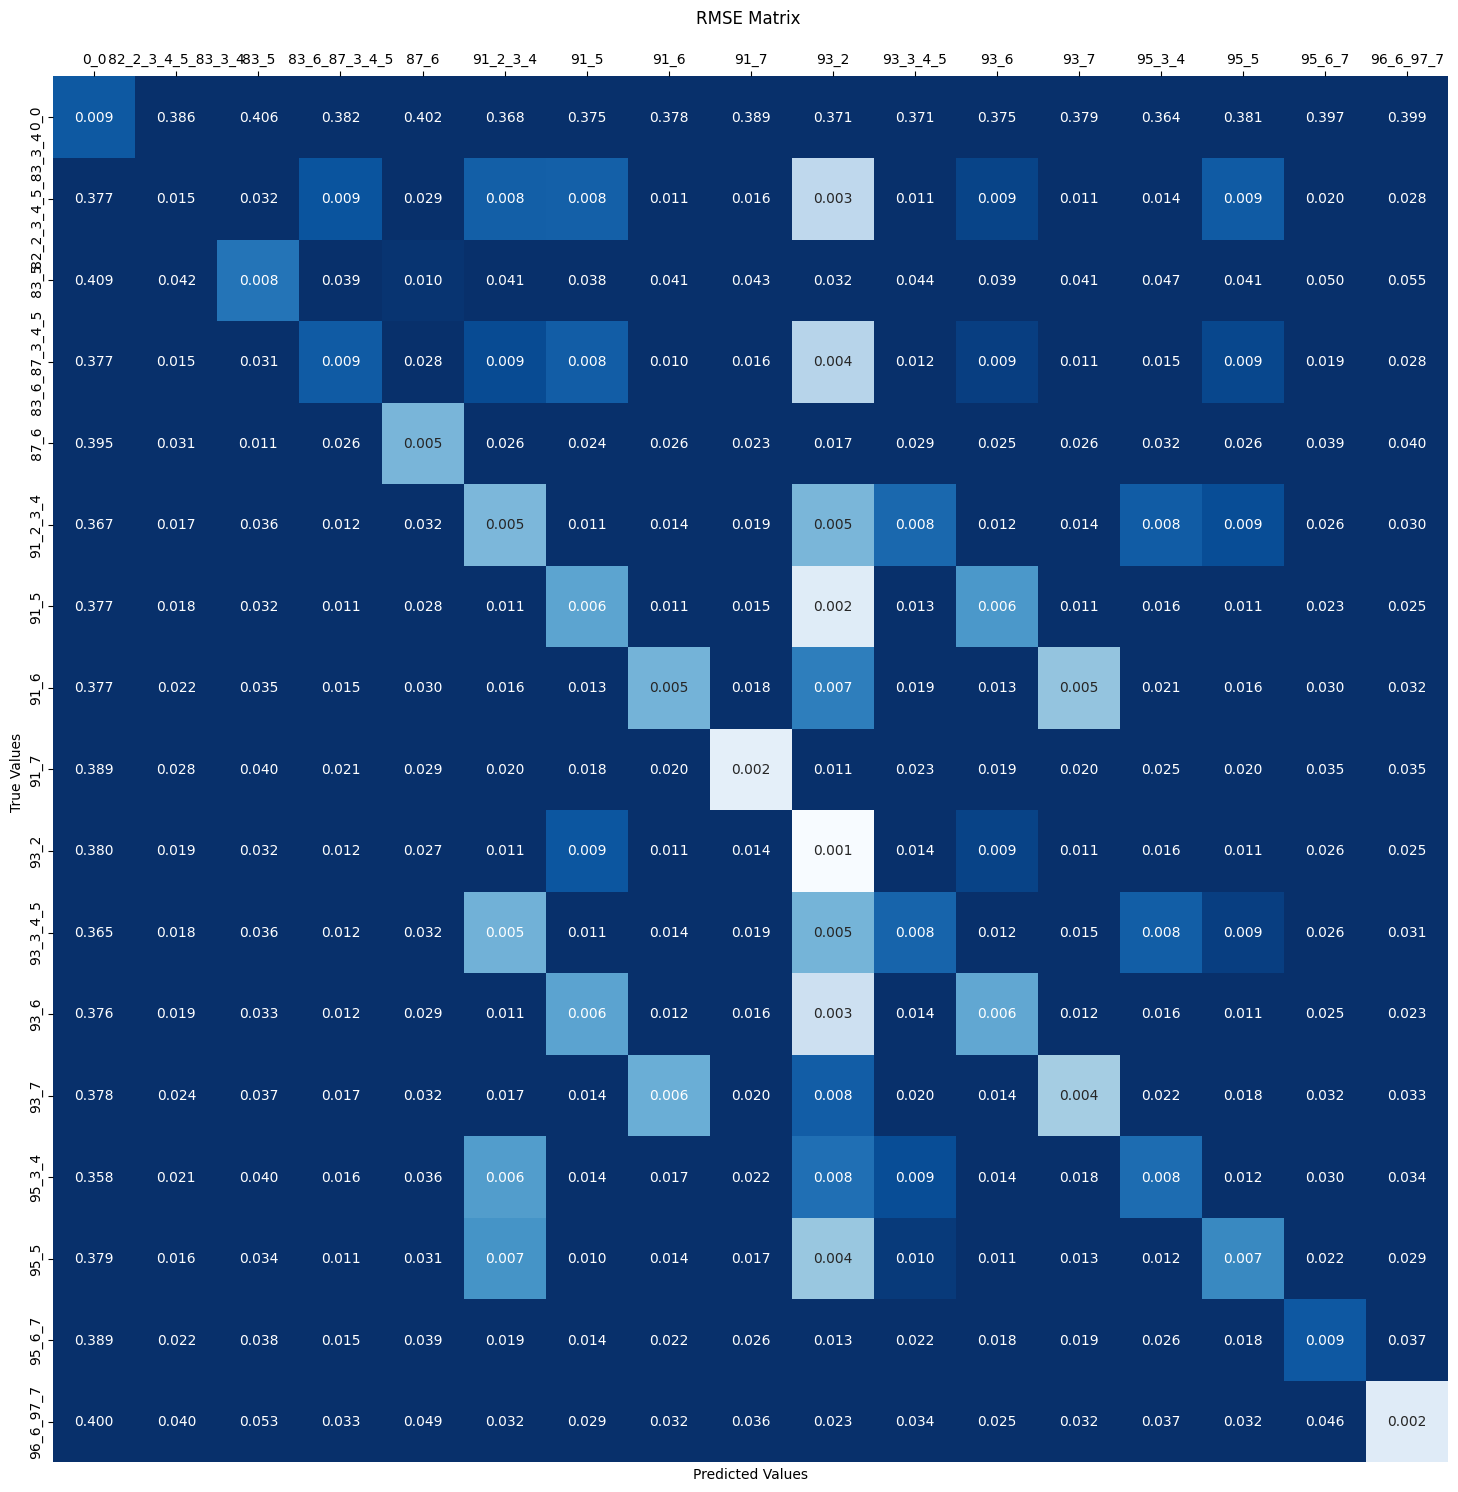

<Figure size 640x480 with 0 Axes>

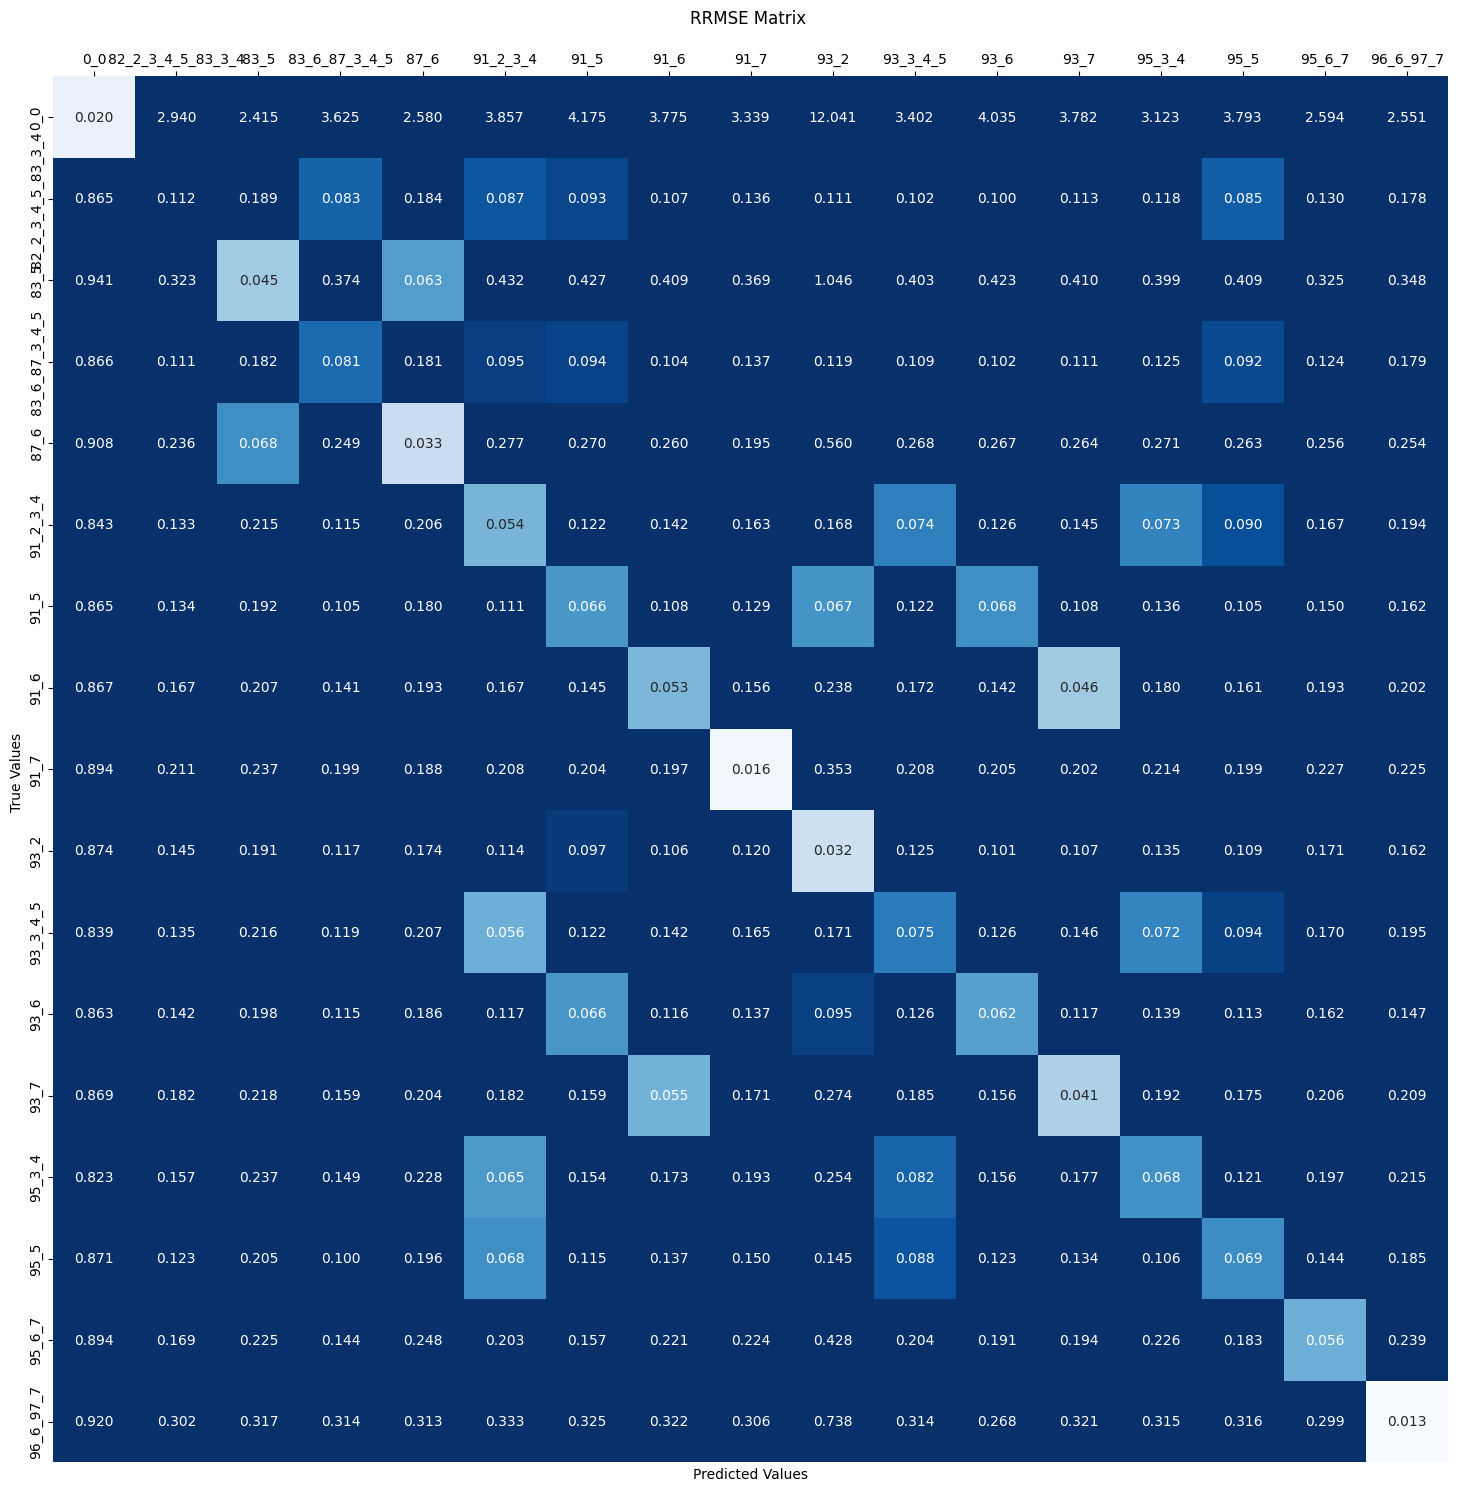

In [71]:
y_ticks= [(i+0.5) for i in range (len(list_combi_17))]


plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(pearson_matrix_17, annot=True, cmap='bwr', fmt=".3f", cbar=False)
fx.set_title('Pearson correlation Matrix \n')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values ')
fx.xaxis.set_ticklabels(list_combi_17)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi_17)
# plt.savefig('Pearson_matrix_sod_50_17_nopatience')
plt.show()

plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(rmse_matrix_17, annot=True, cmap='Blues', fmt=".3f", cbar=False, vmax=0.01)
fx.set_title('RMSE Matrix \n')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values ')
fx.xaxis.set_ticklabels(list_combi_17)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi_17)
# plt.savefig('rmse_matrix_sod_50_17_nopatience')
plt.show()

plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(rrmse_matrix_17, annot=True, cmap='Blues', fmt=".3f", cbar=False,  vmax=0.1)
fx.set_title('RRMSE Matrix \n')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values ')
fx.xaxis.set_ticklabels(list_combi_17)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi_17)
# plt.savefig('rrmse_matrix_sod_50_17_nopatience')
plt.show()


## Matrice 13 

In [72]:
index_remov=[1,3,9,14]

pm1= np.delete(pearson_matrix_17,index_remov,0)
pm2= np.delete(pm1,index_remov,1)

rrmse1= np.delete(rrmse_matrix_17,index_remov,0)
rrmse2= np.delete(rrmse1,index_remov,1)

<Figure size 640x480 with 0 Axes>

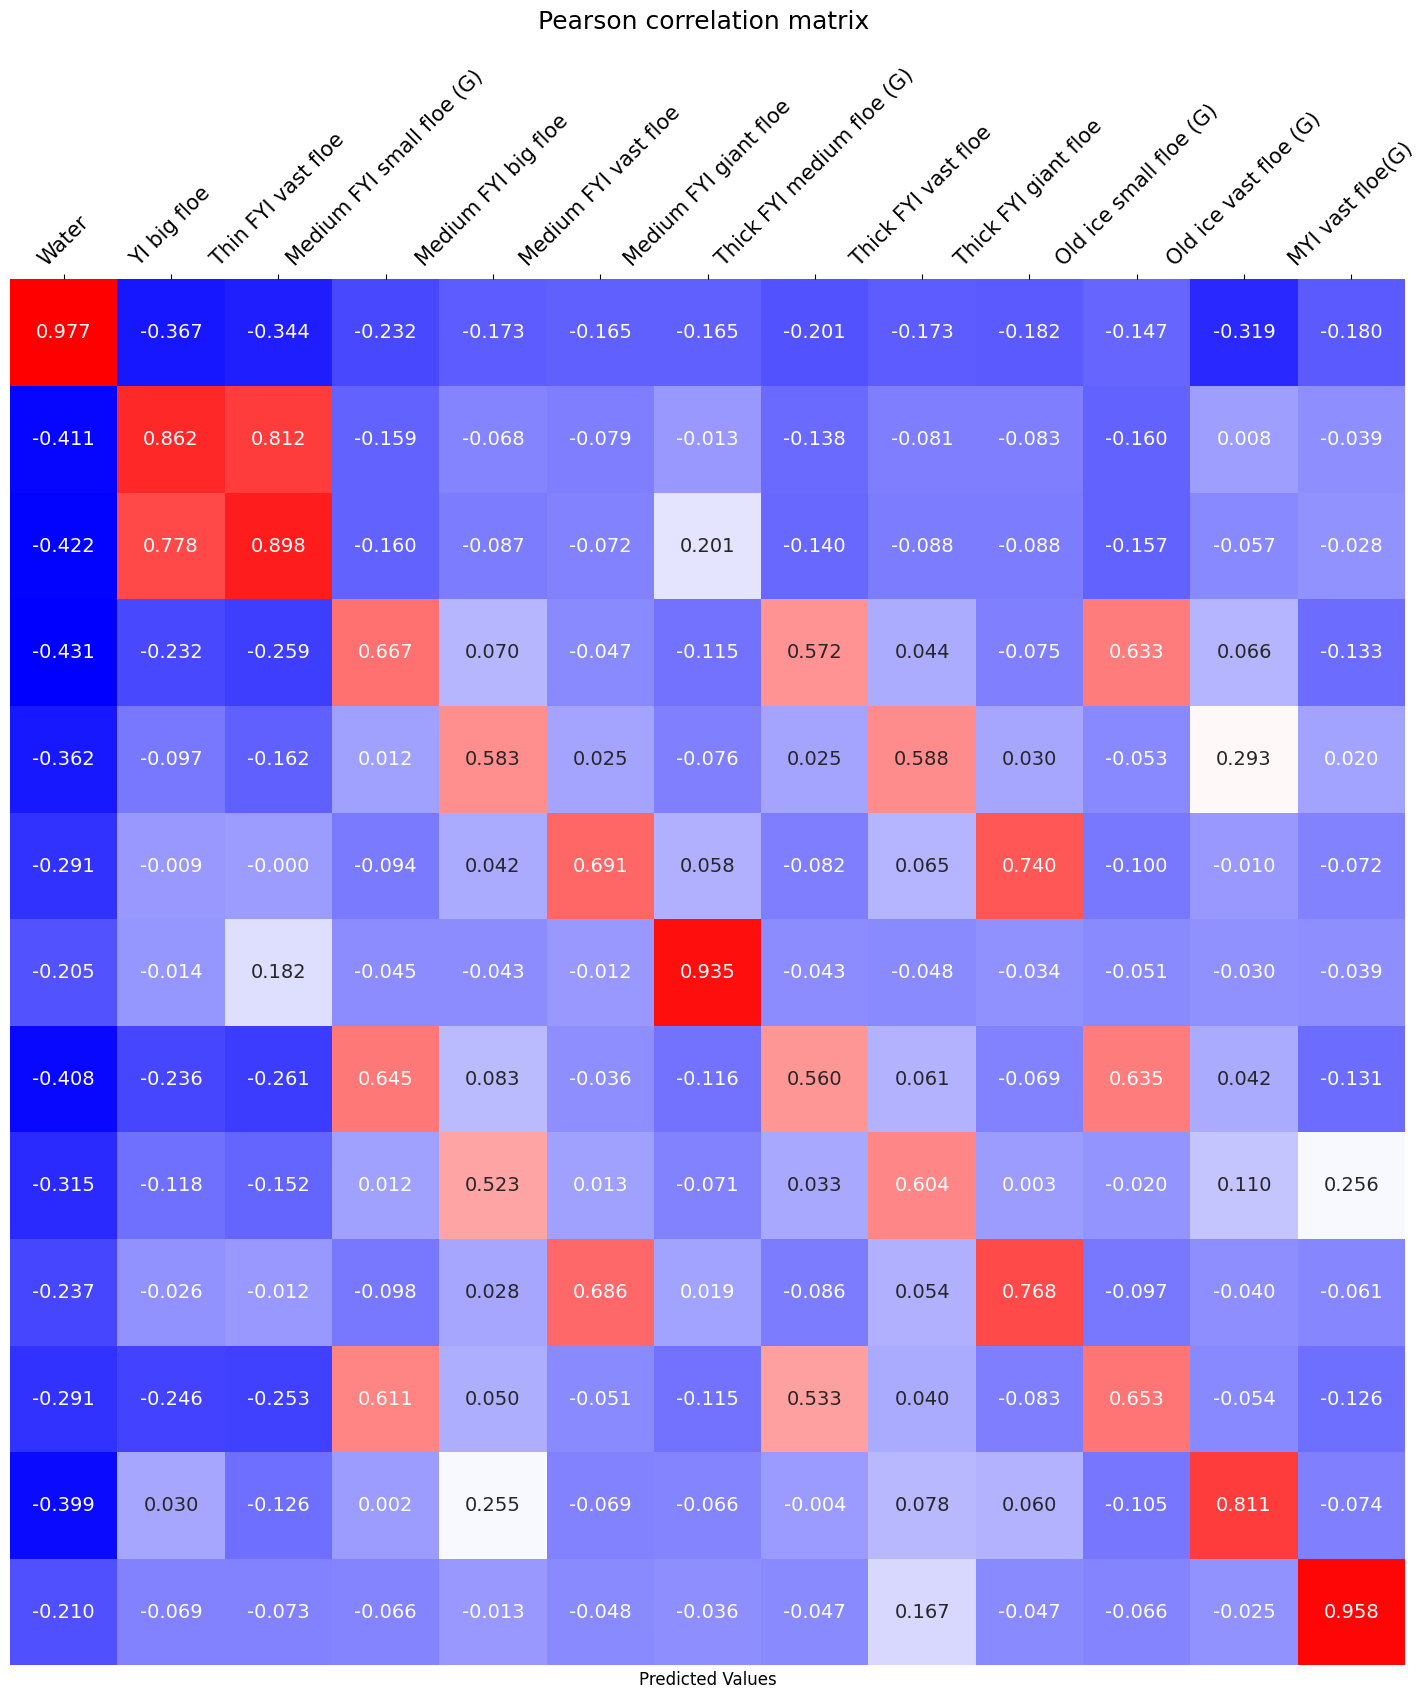

In [75]:
list_combi_clean =["0_0", "83_5", "87_6", "91_2_3_4", "91_5", "91_6", "91_7", "93_3_4_5", "93_6", "93_7","95_3_4", "95_6_7", "96_6_97_7"]    
list_label = ["Water", "YI big floe", "Thin FYI vast floe", "Medium FYI small floe", "Medium FYI big floe", "Medium FYI vast floe", "Medium FYI giant floe",
             "Thick FYI medium floe", "Thick FYI vast floe","Thick FYI giant floe", "Old ice small floe", "Old ice vast floe", "MYI vast floe" ]
list_label = ["Water", "YI big floe", "Thin FYI vast floe", "Medium FYI small floe (G)", "Medium FYI big floe", "Medium FYI vast floe", "Medium FYI giant floe",
             "Thick FYI medium floe (G)", "Thick FYI vast floe","Thick FYI giant floe", "Old ice small floe (G)", "Old ice vast floe (G)", "MYI vast floe(G)" ]
y_ticks= [(i+0.5) for i in range (len(list_combi_clean))]
plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(pm2, annot=True, cmap='bwr', fmt=".3f", cbar=False, annot_kws={"size": 14})
fx.set_title('Pearson correlation matrix \n', fontsize =18)
fx.set_xlabel('Predicted Values', fontsize=12)
fx.set_ylabel('True Values ', fontsize =12)
fx.xaxis.set_ticklabels(list_label, rotation=45, fontsize =15)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi_clean)
fx.get_yaxis().set_visible(False)
# plt.savefig('test')
plt.show()

<Figure size 640x480 with 0 Axes>

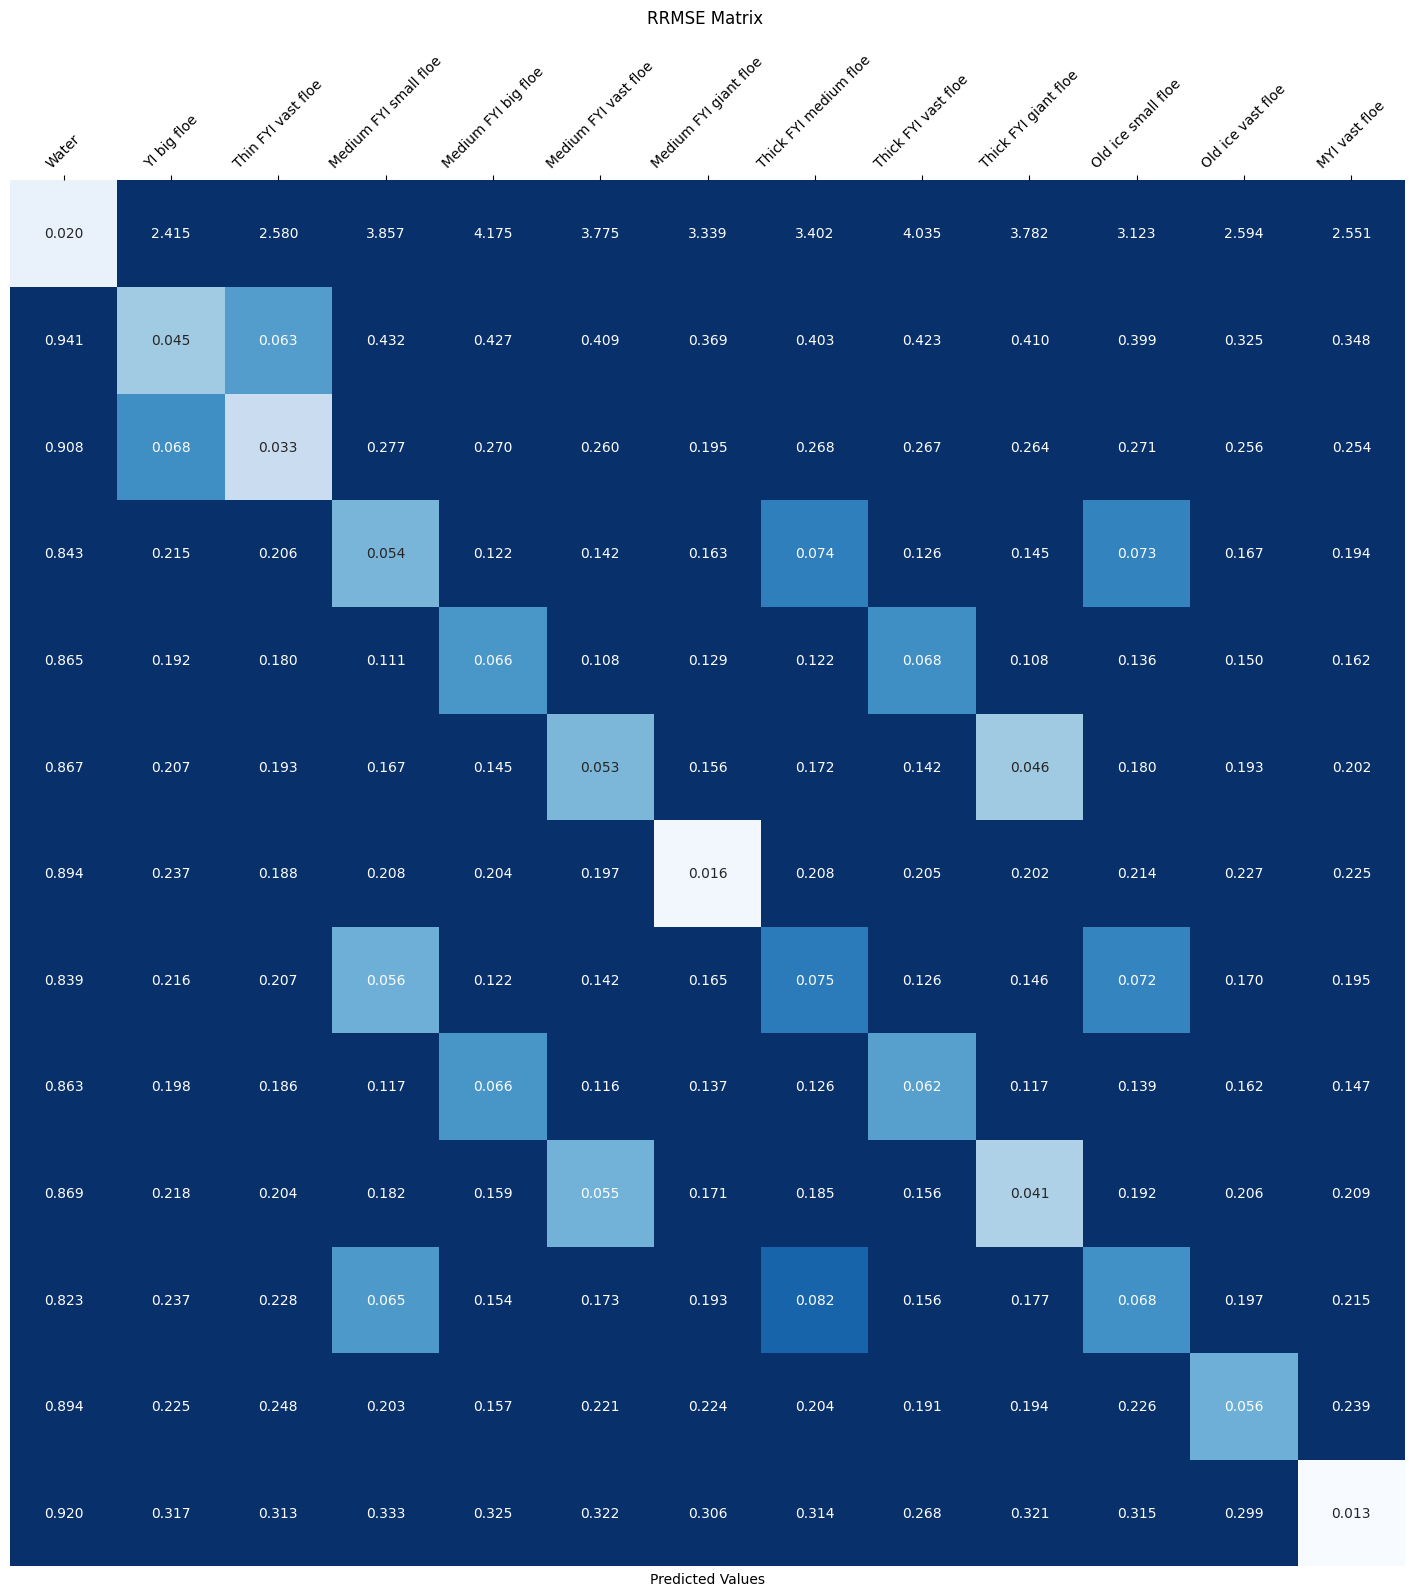

In [74]:
list_combi =["0_0", "82_2_3_4_5_83_3_4", "83_5", "83_6_87_3_4_5", "87_6", "91_2_3_4", "91_5", "91_6", "91_7", "93_2", 
             "93_3_4_5", "93_6", "93_7","95_3_4", "95_5", "95_6_7", "96_6_97_7"]    

y_ticks= [(i+0.5) for i in range (len(list_combi_clean))]
plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(rrmse2, annot=True, cmap='Blues', fmt=".3f", cbar=False, vmax= 0.1)
fx.set_title('RRMSE Matrix \n')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values ')
fx.xaxis.set_ticklabels(list_label, rotation=45)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi_clean)
fx.get_yaxis().set_visible(False)
# plt.savefig('rrmse_matrix_sod_50_17_nopatience_modify')
plt.show()

# Network 17

In [110]:
idir_pre = '/tf/data/hugo_sod/output_inference_check/'
input_dir_json = '/tf/data/hugo_sod/'
idir_model_17 = '/tf/sea_ice_type_cnn_training/asip_v2/CNN_sod_f/17 classes/model_sod_50_17_nopatience/'

In [111]:
model17 = keras.models.load_model(idir_model_17)

In [112]:
validation_generator_17 = DataGenerator_sod_f(valid_files, **params)

In [113]:
y_val_17 = np.vstack([vg[1] for vg in validation_generator_17])
y_pred_17 = model17.predict(validation_generator_17)

5331/5331 [==============================] - 1558s 292ms/step


In [114]:
rmse_m_17=np.empty((17,17))
pearson_m_17 = np.empty((17,17))
rrmse_m_17=np.empty((17,17))
for id_class_pred in range(y_pred_17.shape[1]):
    classes_pred = y_pred_17[:,id_class_pred]
    for id_class_val in range (y_val_17.shape[1]):
        classes_val = y_val_17[:,id_class_val]
        rmse = mean_squared_error(classes_val, classes_pred)
        rmse_m_17[id_class_pred][id_class_val] = rmse
        rrmse = rmse / classes_val.std()
        rrmse_m_17[id_class_pred][id_class_val] = rrmse
        pearson_value = stats.pearsonr(classes_val, classes_pred)
        pearson_m_17[id_class_pred][id_class_val] = pearson_value[0]

In [115]:
index_remov=[1,3,9,14]

pm1_17= np.delete(pearson_m_17,index_remov,0)
pm2_17= np.delete(pm1_17,index_remov,1)

rrmse1_17= np.delete(rrmse_m_17,index_remov,0)
rrmse2_17= np.delete(rrmse1_17,index_remov,1)

<Figure size 640x480 with 0 Axes>

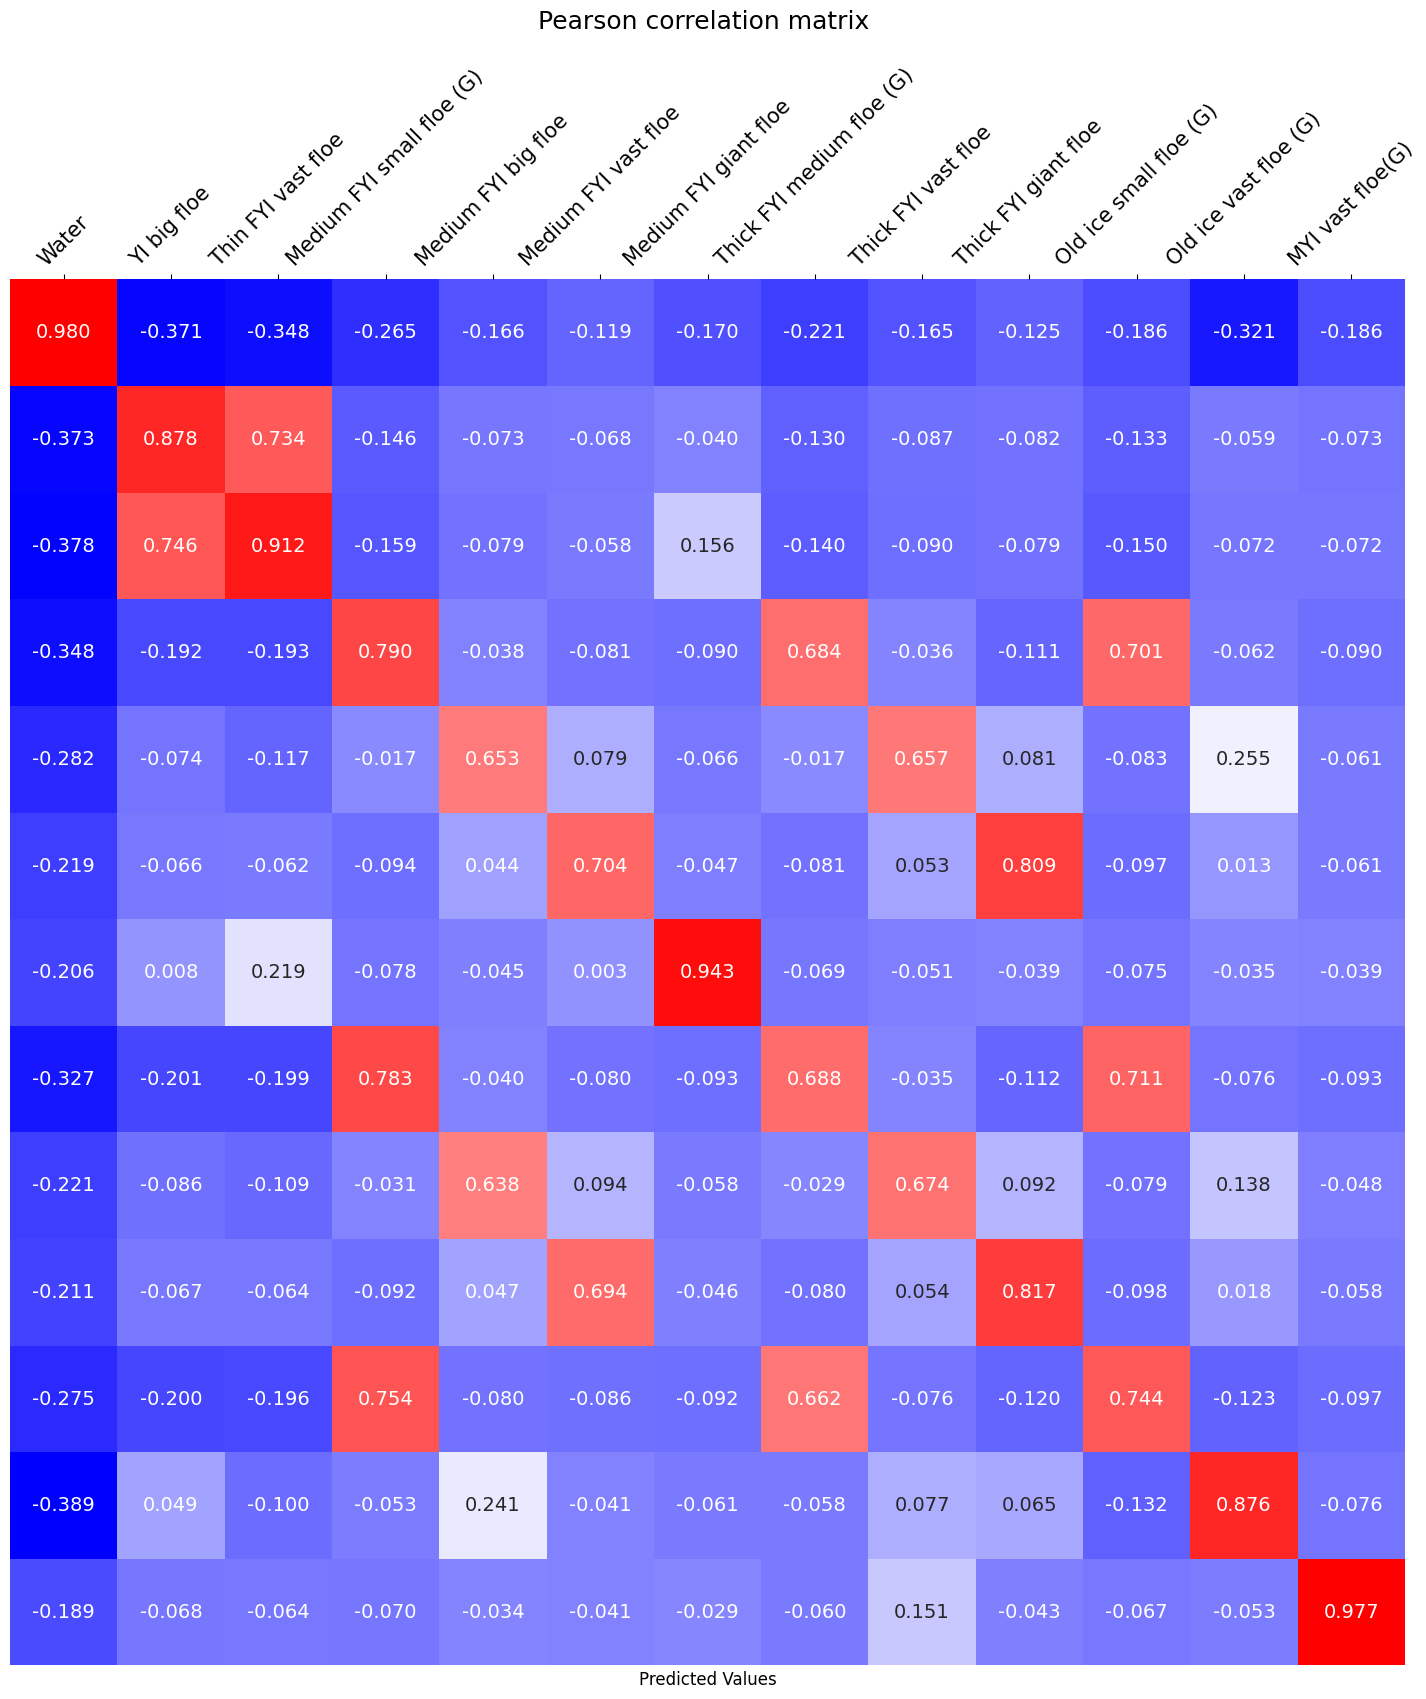

In [116]:
list_label = ["Water", "YI big floe", "Thin FYI vast floe", "Medium FYI small floe (G)", "Medium FYI big floe", "Medium FYI vast floe", "Medium FYI giant floe",
             "Thick FYI medium floe (G)", "Thick FYI vast floe","Thick FYI giant floe", "Old ice small floe (G)", "Old ice vast floe (G)", "MYI vast floe(G)" ]
y_ticks= [(i+0.5) for i in range (len(list_combi_clean))]
plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(pm2_17, annot=True, cmap='bwr', fmt=".3f", cbar=False, annot_kws={"size": 14})
fx.set_title('Pearson correlation matrix \n', fontsize =18)
fx.set_xlabel('Predicted Values', fontsize=12)
fx.set_ylabel('True Values ', fontsize =12)
fx.xaxis.set_ticklabels(list_label, rotation=45, fontsize =15)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi_clean)
fx.get_yaxis().set_visible(False)
# plt.savefig('test')
plt.show()

# 4 classes grouping

In [208]:
list_index_sum_4 = [0,[1,2,3,4,5,6,7,8],[9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],[25,26,27,28,29,30,31]]
list_index_sum_pred_4 =[0,[1,9,12,19,23,24,25,31],[2,3,6,10,11,13,14,16,17,18,20,22,26,27,28,29],[4,5,7,8,15,21,30]]

In [209]:
samples_4_val =[0]*4
samples_4_pred =[0]*4
for sample_val, sample_pred in zip (y_val, y_pred):
    sample_val_4 =[]
    sample_pred_4 =[]
    for index in list_index_sum_4:
        sum_group_val= np.sum(np.array([sample_val[index]]))
        sample_val_4.append(sum_group_val)
    for index_pre in list_index_sum_pred_4:
        sum_group_pred= np.sum(np.array([sample_pred[index_pre]]))
        sample_pred_4.append(sum_group_pred)
    samples_4_val = np.vstack((samples_4_val, sample_val_4))
    samples_4_pred = np.vstack((samples_4_pred, sample_pred_4))

In [210]:
samples_4_val =samples_4_val[1:]
samples_4_pred=samples_4_pred[1:]

In [211]:
print(samples_4_val.shape)

(255596, 4)


In [212]:
rmse_matrix_4 = np.empty((4,4))
pearson_matrix_4 = np.empty((4,4))
rrmse_matrix_4 = np.empty((4,4))
for id_class_pred in range(samples_4_pred.shape[1]):
    classes_pred = samples_4_pred[:,id_class_pred]
    for id_class_val in range (samples_4_val.shape[1]):
        classes_val = samples_4_val[:,id_class_val]
        rmse = mean_squared_error(classes_val, classes_pred)
        rmse_matrix_4[id_class_pred][id_class_val] = rmse
        rrmse = rmse / classes_val.std()
        rrmse_matrix_4[id_class_pred][id_class_val] = rrmse
        pearson_value = stats.pearsonr(classes_val, classes_pred)
        pearson_matrix_4[id_class_pred][id_class_val] = pearson_value[0]

<Figure size 640x480 with 0 Axes>

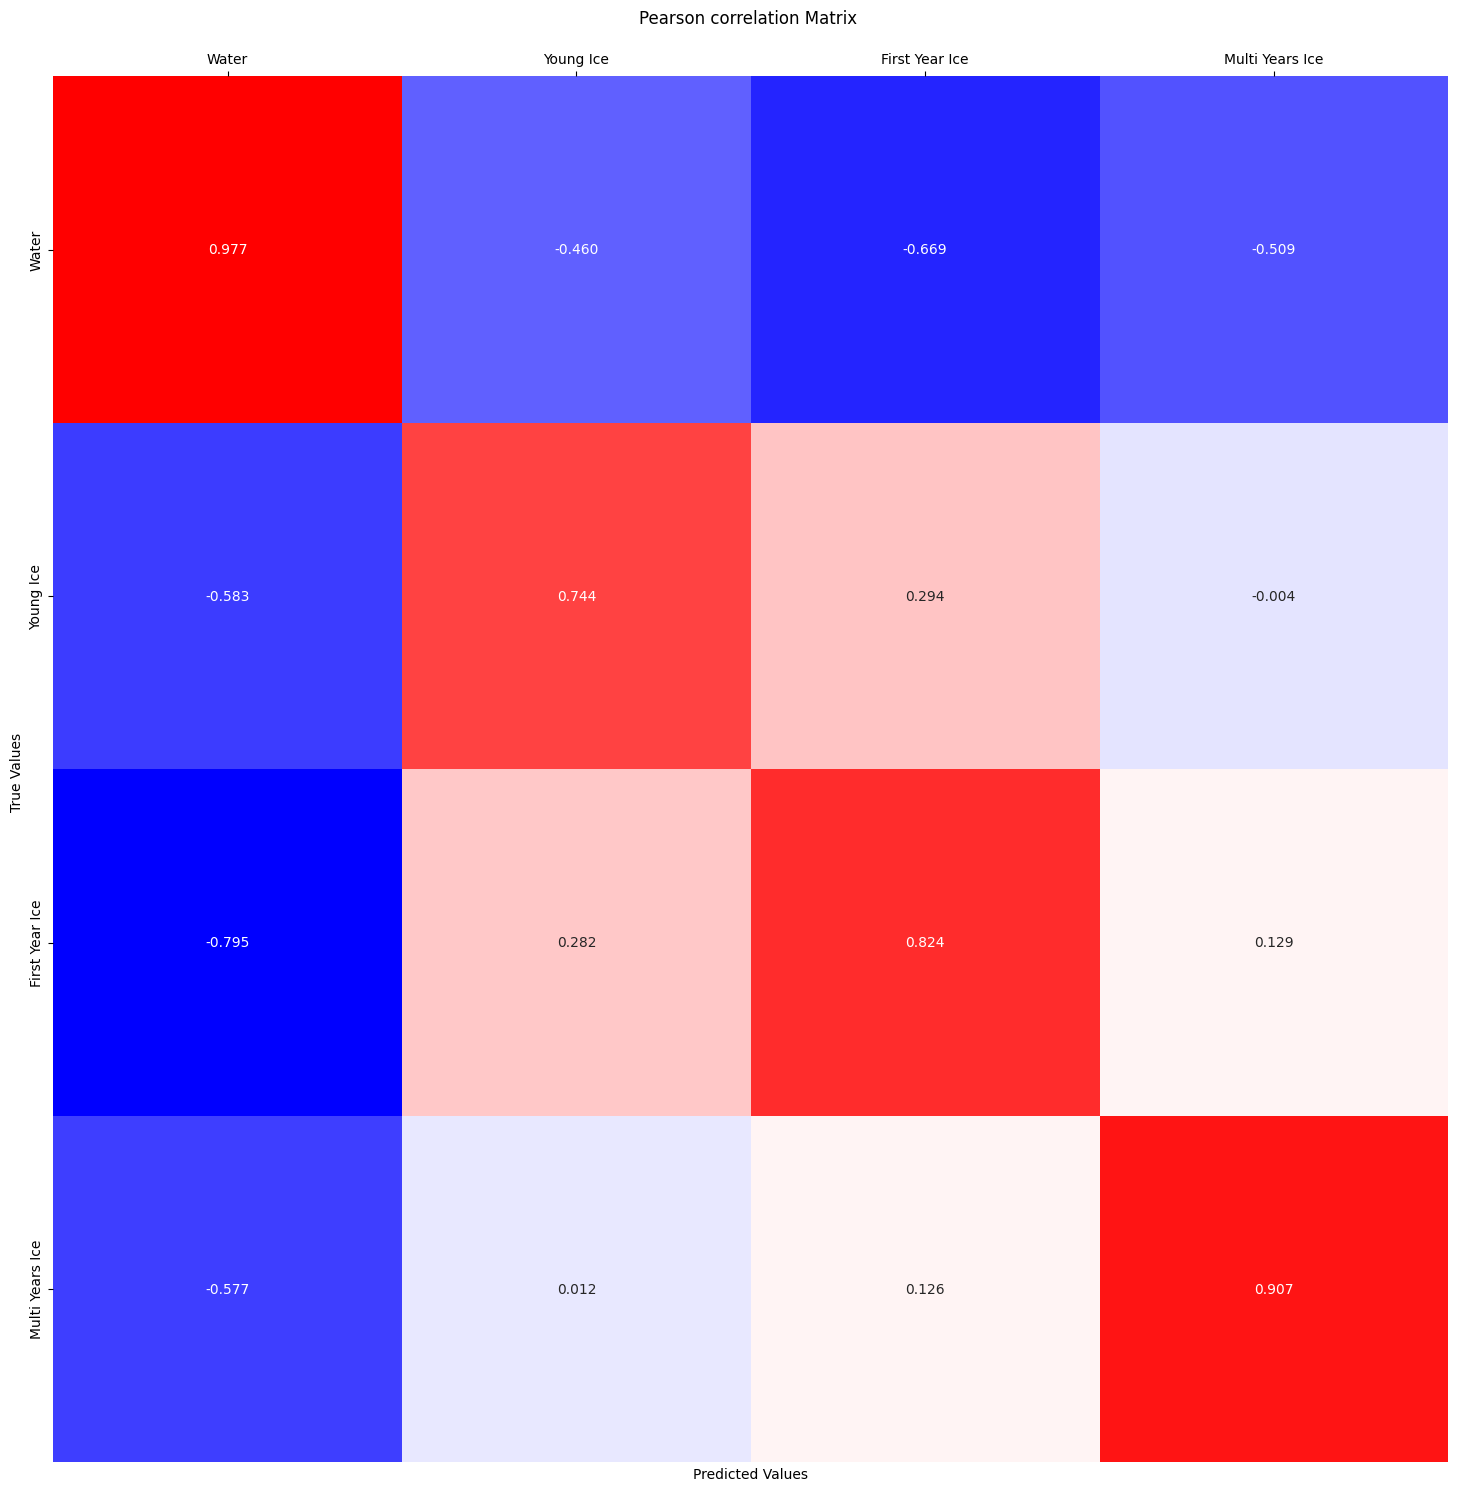

<Figure size 640x480 with 0 Axes>

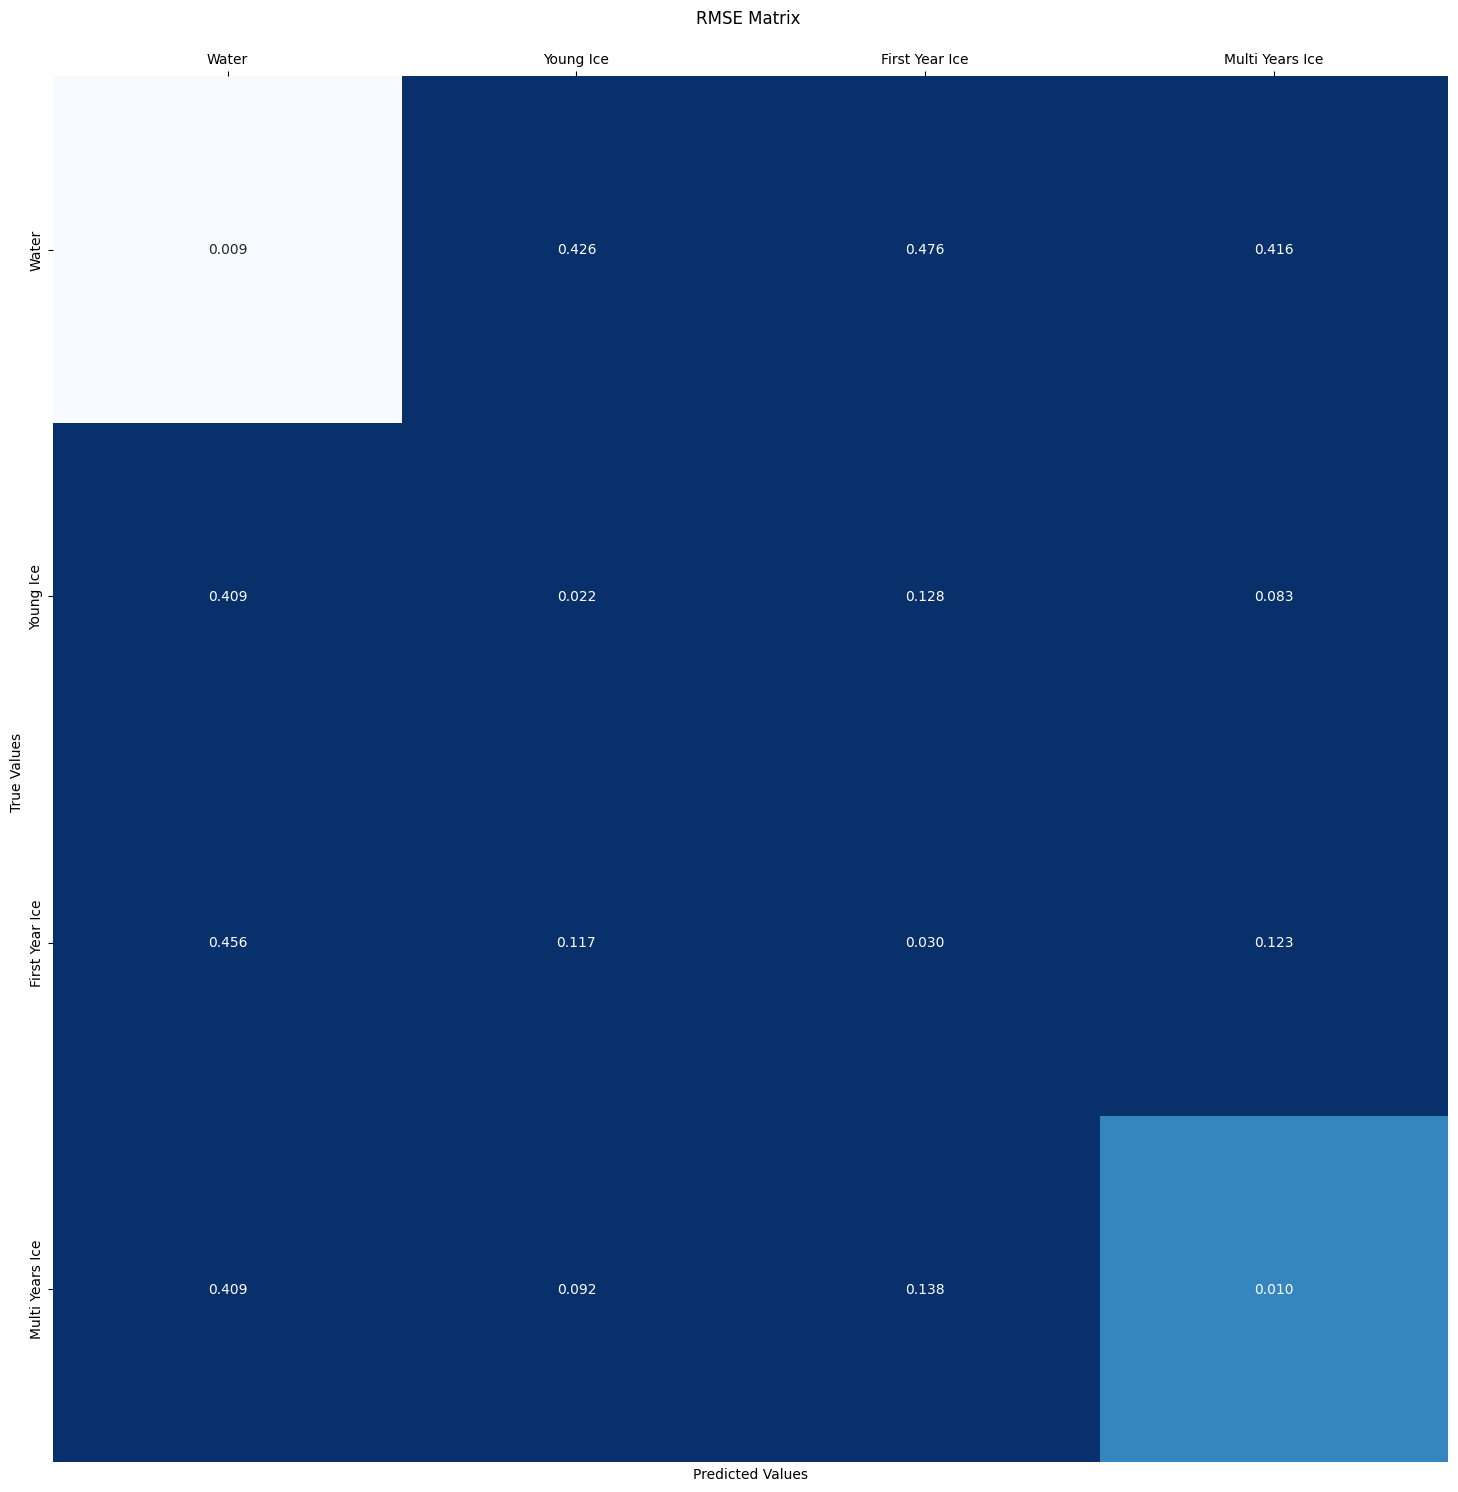

<Figure size 640x480 with 0 Axes>

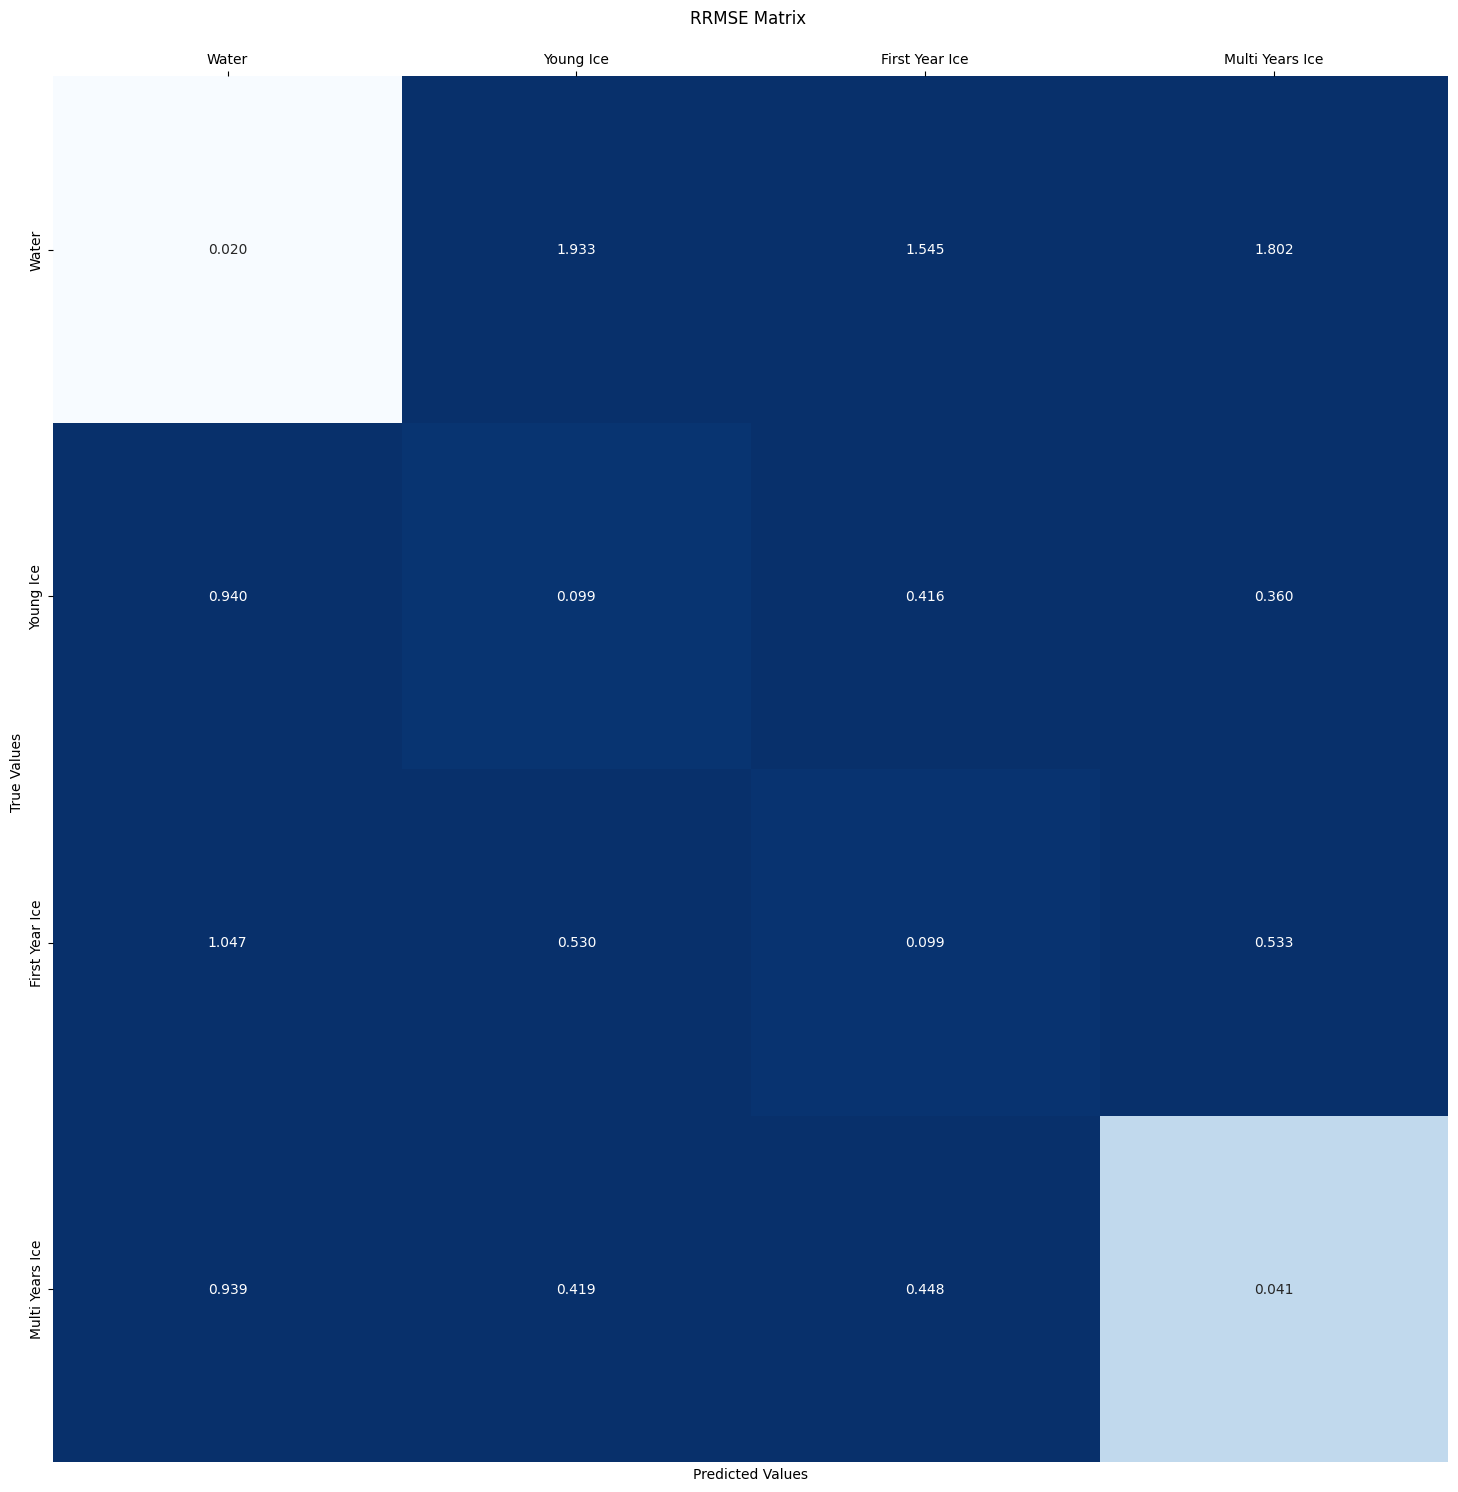

In [213]:
list_combi_4=["Water", "Young Ice", "First Year Ice", "Multi Years Ice"]

y_ticks= [(i+0.5) for i in range (len(list_combi_4))]


plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(pearson_matrix_4, annot=True, cmap='bwr', fmt=".3f", cbar=False)
fx.set_title('Pearson correlation Matrix \n')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values ')
fx.xaxis.set_ticklabels(list_combi_4)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi_4)
# plt.savefig('Pearson_matrix_sod_50_17_nopatience')
plt.show()

plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(rmse_matrix_4, annot=True, cmap='Blues', fmt=".3f", cbar=False, vmax=0.01)
fx.set_title('RMSE Matrix \n')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values ')
fx.xaxis.set_ticklabels(list_combi_4)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi_4)
# plt.savefig('rmse_matrix_sod_50_17_nopatience')
plt.show()

plt.clf()
plt.figure(figsize=(18,18))
fx = sebrn.heatmap(rrmse_matrix_4, annot=True, cmap='Blues', fmt=".3f", cbar=False,  vmax=0.1)
fx.set_title('RRMSE Matrix \n')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values ')
fx.xaxis.set_ticklabels(list_combi_4)
fx.xaxis.tick_top()
fx.set_yticks(y_ticks)
fx.yaxis.set_ticklabels(ticklabels=list_combi_4)
# plt.savefig('rrmse_matrix_sod_50_17_nopatience')
plt.show()


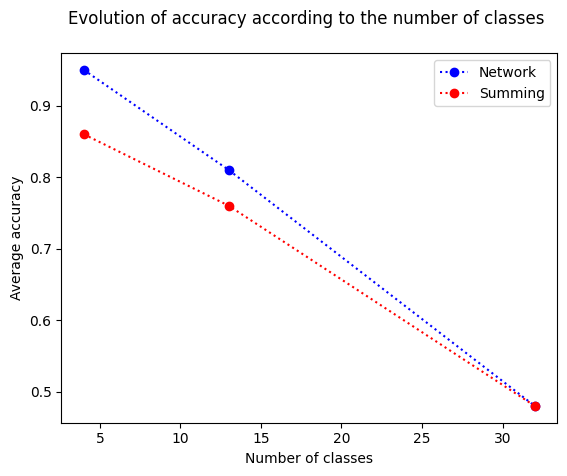

In [216]:
X_class = [4, 13, 32]
Y_acc_net = [0.95, 0.81, 0.48]
Y_acc_sum =[0.86, 0.76, 0.48]
plt.plot(X_class,Y_acc_net,"b:o", label = 'Network')
plt.plot(x_class,Y_acc_sum,"r:o", label = 'Summing')
plt.legend()
plt.title('Evolution of accuracy according to the number of classes \n')
plt.xlabel('Number of classes')
plt.ylabel('Average accuracy')
plt.show()

# Graph

In [136]:
list_91_2_v =[]
list_91_3_v =[]
list_91_4_v =[]
list_91_2_p =[]
list_91_3_p =[]
list_91_4_p =[]

list_91_p =[]
list_91_v =[]

for sample_v, sample_p in zip(y_val, y_pred):
    list_91_2_v.append(sample_v[13])
    list_91_3_v.append(sample_v[14])
    list_91_4_v.append(sample_v[15])
    list_91_2_p.append(sample_p[17])
    list_91_3_p.append(sample_p[11])
    list_91_4_p.append(sample_p[16])
    
for sample_v, sample_p in zip(y_val_17, y_pred_17):
    list_91_v.append(sample_v[5])
    list_91_p.append(sample_p[5])    

list_91_v_32=[]
list_91_p_32=[]

for i in range (len(list_91_2_v)):
    v= list_91_2_v[i] + list_91_3_v[i] + list_91_4_v[i]
    p= list_91_2_p[i] + list_91_3_p[i] + list_91_4_p[i]
    list_91_v_32.append(v)
    list_91_p_32.append(p)
    

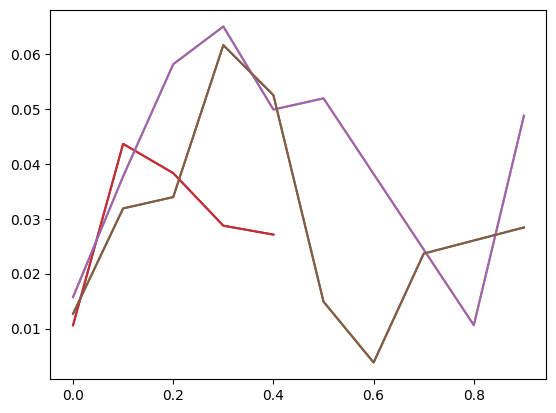

In [194]:
v_idx = [13,14,15]
p_idx = [17,11,16]

vp32 = []
for vi, pi in zip(v_idx, p_idx):
    vp32.append(
        {
            'v': np.array(y_val)[:, vi],
            'p': np.array(y_pred)[:, pi],
        })


for vp in vp32:
    x = np.unique(vp['v'])
    X = []
    Y = []
    E = []
    for i in x:
        gpi = vp['v'] == i
        X.append(vp['v'][gpi].mean())
        Y.append(vp['p'][gpi].mean())
        E.append(vp['p'][gpi].std())
    plt.plot(X, Y)
plt.show()

In [190]:
vp32[0]['v']

array([0. , 0. , 0.3, ..., 0. , 0. , 0. ])

<ipython-input-222-dc7f085cc8af>:84: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(X_4, Y_4, 'o', label = '91_13_cnn', color='c',marker="^")


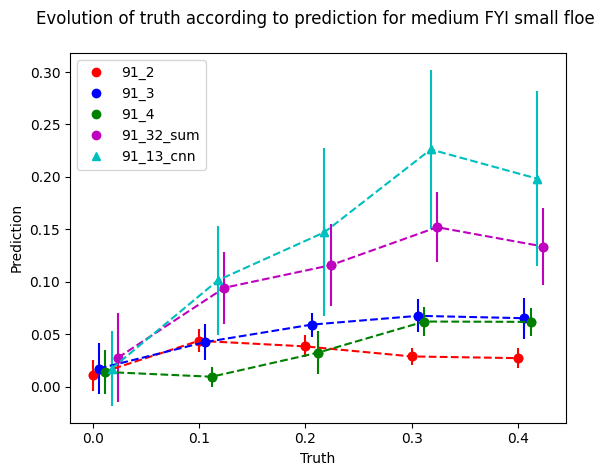

In [222]:
X=[]
Y=[]
E=[]
x=np.unique(list_91_2_v)
for i in x:
    X.append(i)
    l=[]
    for j in range(len(list_91_2_p)):
        if list_91_2_v[j]==i:
            l.append(list_91_2_p[j])
    Y.append(np.mean(l))
    E.append(np.std(l))


X_2=[]
Y_2=[]
E_2=[]
x=np.unique(list_91_3_v)
for i in x:
    X_2.append(i+0.006)
    l=[]
    for j in range(len(list_91_3_p)):
        if list_91_2_v[j]==i:
            l.append(list_91_3_p[j])
    Y_2.append(np.mean(l))
    E_2.append(np.std(l))
    
X_3=[]
Y_3=[]
E_3=[]
x=np.unique(list_91_4_v)
for i in x:
    X_3.append(i+0.012)
    l=[]
    for j in range(len(list_91_4_p)):
        if list_91_2_v[j]==i:
            l.append(list_91_4_p[j])
    Y_3.append(np.mean(l))
    E_3.append(np.std(l))
    
X_4=[]
Y_4=[]
E_4=[]
S_4 = []
x=np.unique(list_91_v)
for i in x:
    l=[]
    for j in range(len(list_91_p)):
        if list_91_v[j]==i:
            l.append(list_91_p[j])
    if len(l) > 100:
        X_4.append(i+0.018)
        Y_4.append(np.mean(l))
        E_4.append(np.std(l))
        S_4.append(len(l))
    
X_5=[]
Y_5=[]
E_5=[]
S_5=[]

x=np.unique(list_91_v_32)
for i in x:
    l=[]
    for j in range(len(list_91_p_32)):
        if list_91_v_32[j]==i:
            l.append(list_91_p_32[j])
    if len(l) > 100:
        X_5.append(i+0.024)
        Y_5.append(np.mean(l))
        E_5.append(np.std(l))
        S_5.append(len(l))

plt.clf()
plt.plot(X, Y, 'o', label = '91_2', color="r")
plt.errorbar(X, Y, E, fmt = '--ro')
plt.plot(X_2, Y_2, 'o', label = '91_3', color="b")
plt.errorbar(X_2, Y_2, E_2, fmt = '--bo')
plt.plot(X_3, Y_3, 'o', label = '91_4', color='g')
plt.errorbar(X_3, Y_3, E_3, fmt = '--go')
plt.plot(X_5, Y_5, 'o', label = '91_32_sum', color='m')
plt.errorbar(X_5, Y_5, E_5, fmt = '--mo')

plt.plot(X_4, Y_4, 'o', label = '91_13_cnn', color='c',marker="^")
plt.errorbar(X_4, Y_4, E_4, fmt = '--c^')
plt.legend()
plt.title('Evolution of truth according to prediction for medium FYI small floe \n')
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()

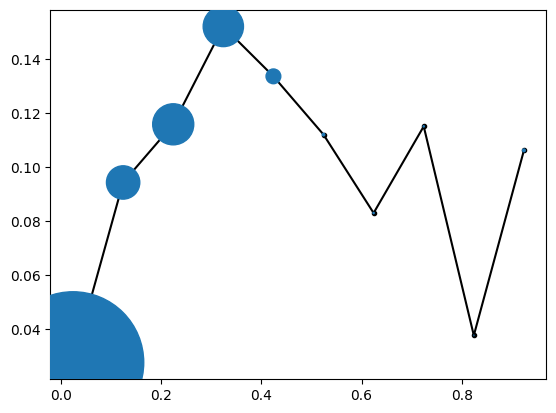

In [184]:
plt.plot(X_5, Y_5, 'k.-')
plt.scatter(X_5, Y_5, np.array(S_5)/20, zorder=10 )
plt.show()

#plt.plot(X_5, Y_5, 'k.-')
#plt.scatter(X_5, Y_5, 30, np.log10(S_5), cmap='jet', zorder=10 )
#plt.colorbar()
#plt.show()

### 95_3_95_4

In [143]:
list_95_3_v =[]
list_95_4_v =[]
list_95_3_p =[]
list_95_4_p =[]
list_95_v =[]
list_95_p =[]

for sample_v, sample_p in zip(y_val, y_pred):
    list_95_3_v.append(sample_v[25])
    list_95_4_v.append(sample_v[26])
    list_95_3_p.append(sample_p[7])
    list_95_4_p.append(sample_p[4])
    
for sample_v, sample_p in zip(y_val_17, y_pred_17):
    list_95_v.append(sample_v[13])
    list_95_p.append(sample_p[13])
    
list_95_v_32=[]
list_95_p_32=[]

for i in range (len(list_95_3_v)):
    v= list_95_3_v[i] + list_95_4_v[i] 
    p= list_95_3_p[i] + list_95_4_p[i] 
    list_95_v_32.append(v)
    list_95_p_32.append(p)
    

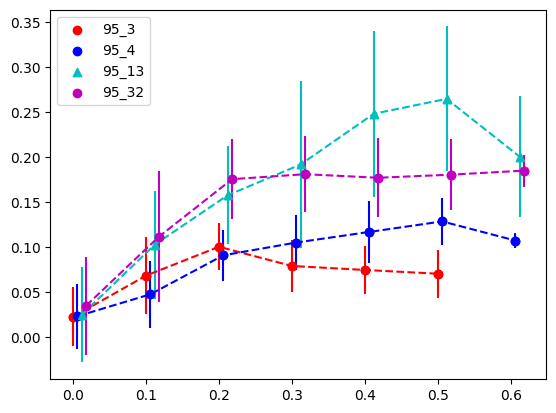

In [221]:
X2=[]
Y2=[]
E2=[]
x=np.unique(list_95_3_v)
for i in x:
    X2.append(i)
    l=[]
    for j in range(len(list_95_3_p)):
        if list_95_3_v[j]==i:
            l.append(list_95_3_p[j])
    Y2.append(np.mean(l))
    E2.append(np.std(l))


X2_2=[]
Y2_2=[]
E2_2=[]
x=np.unique(list_95_4_v)
for i in x:
    X2_2.append(i+0.006)
    l=[]
    for j in range(len(list_95_4_p)):
        if list_95_4_v[j]==i:
            l.append(list_95_4_p[j])
    Y2_2.append(np.mean(l))
    E2_2.append(np.std(l))
    
X2_3=[]
Y2_3=[]
E2_3=[]
x=np.unique(list_95_v)
for i in x:
    X2_3.append(i+0.012)
    l=[]
    for j in range(len(list_95_p)):
        if list_95_v[j]==i:
            l.append(list_95_p[j])
    Y2_3.append(np.mean(l))
    E2_3.append(np.std(l))
        
X2_5=[]
Y2_5=[]
E2_5=[]
x=np.unique(list_95_v_32)
for i in x:
    X2_5.append(i+0.018)
    l=[]
    for j in range(len(list_95_p_32)):
        if list_95_v_32[j]==i:
            l.append(list_95_p_32[j])
    Y2_5.append(np.mean(l))
    E2_5.append(np.std(l))
    
plt.clf()
plt.scatter(X2, Y2, label = '95_3', color='r')
plt.errorbar(X2, Y2, E2, fmt = '--ro')
plt.scatter(X2_2, Y2_2, label = '95_4', color='b')
plt.errorbar(X2_2, Y2_2, E2_2, fmt = '--bo')
plt.scatter(X2_3, Y2_3, label = '95_13', color='c',marker="^")
plt.errorbar(X2_3, Y2_3, E2_3, fmt = '--c^')
plt.scatter(X2_5, Y2_5, label = '95_32', color='m')
plt.errorbar(X2_5, Y2_5, E2_5, fmt = '--mo')

plt.legend()
plt.show()

### 96_6_97_7

In [164]:
list_96_6_v =[]
list_97_7_v =[]
list_96_6_p =[]
list_97_7_p =[]
list_96_v =[]
list_96_p =[]

for sample_v, sample_p in zip(y_val, y_pred):
    list_96_6_v.append(sample_v[30])
    list_97_7_v.append(sample_v[31])
    list_96_6_p.append(sample_p[15])
    list_97_7_p.append(sample_p[21])
    
for sample_v, sample_p in zip(y_val_17, y_pred_17):
    list_96_v.append(sample_v[16])
    list_96_p.append(sample_p[16])
    
list_96_v_32=[]
list_96_p_32=[]

for i in range (len(list_96_6_v)):
    v= list_96_6_v[i] + list_97_7_v[i]
    p= list_96_6_p[i] + list_97_7_p[i] 
    list_96_v_32.append(np.round(v,1))
    list_96_p_32.append(p)
    

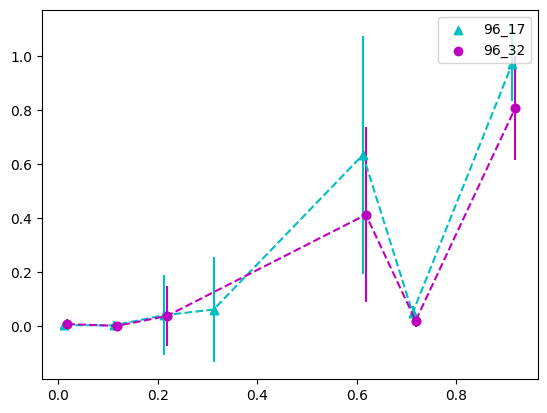

In [167]:
X3=[]
Y3=[]
E3=[]
x=np.unique(list_96_6_v)
for i in x:
    X3.append(i)
    l=[]
    for j in range(len(list_96_6_p)):
        if list_96_6_v[j]==i:
            l.append(list_96_6_p[j])
    Y3.append(np.mean(l))
    E3.append(np.std(l))


X3_2=[]
Y3_2=[]
E3_2=[]
x=np.unique(list_97_7_v)
for i in x:
    X3_2.append(i+0.006)
    l=[]
    for j in range(len(list_97_7_p)):
        if list_97_7_v[j]==i:
            l.append(list_97_7_p[j])
    Y3_2.append(np.mean(l))
    E3_2.append(np.std(l))
    
X3_3=[]
Y3_3=[]
E3_3=[]
x=np.unique(list_96_v)
for i in x:
    X3_3.append(i+0.012)
    l=[]
    for j in range(len(list_96_p)):
        if list_96_v[j]==i:
            l.append(list_96_p[j])
    Y3_3.append(np.mean(l))
    E3_3.append(np.std(l))
        
X3_5=[]
Y3_5=[]
E3_5=[]
x=np.unique(list_96_v_32)
for i in x:
    X3_5.append(i+0.018)
    l=[]
    for j in range(len(list_96_p_32)):
        if list_96_v_32[j]==i:
            l.append(list_96_p_32[j])
    Y3_5.append(np.mean(l))
    E3_5.append(np.std(l))
    
plt.clf()
# plt.scatter(X3, Y3, label = '96_6', color='r')
# plt.errorbar(X3, Y3, E3, fmt = '--ro')
# plt.scatter(X3_2, Y3_2, label = '97_7', color='b')
# plt.errorbar(X3_2, Y3_2, E3_2, fmt = '--bo')
plt.scatter(X3_3, Y3_3, label = '96_17', color='c',marker="^")
plt.errorbar(X3_3, Y3_3, E3_3, fmt = '--c^')
plt.scatter(X3_5, Y3_5, label = '96_32', color='m')
plt.errorbar(X3_5, Y3_5, E3_5, fmt = '--mo')
plt.legend()
plt.show()